<a href="https://colab.research.google.com/github/hawkh/hackathons/blob/main/Wav2Vec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patool
!pip install -q transformers torch torchaudio scikit-learn tqdm accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Datasets/smartearsaudio (2).zip", outdir="/content/")

INFO patool: Extracting /content/drive/MyDrive/Datasets/smartearsaudio (2).zip ...
INFO:patool:Extracting /content/drive/MyDrive/Datasets/smartearsaudio (2).zip ...
INFO patool: running /usr/bin/7z x -aou -o/content/ -- "/content/drive/MyDrive/Datasets/smartearsaudio (2).zip"
INFO:patool:running /usr/bin/7z x -aou -o/content/ -- "/content/drive/MyDrive/Datasets/smartearsaudio (2).zip"
INFO patool: ... /content/drive/MyDrive/Datasets/smartearsaudio (2).zip extracted to `/content/'.
INFO:patool:... /content/drive/MyDrive/Datasets/smartearsaudio (2).zip extracted to `/content/'.


'/content/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import os
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

def setup_gpu():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

        # T4 GPU optimizations
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True

        # Clear GPU cache
        torch.cuda.empty_cache()
        gc.collect()
    else:
        device = torch.device('cpu')
        print("⚠️  CUDA not available, using CPU (this will be much slower)")
        print("To use GPU in Colab: Runtime > Change runtime type > Hardware accelerator: GPU")

    return device

class ChickenSoundDataset(Dataset):
    def __init__(self, root_dir, processor, max_length=16000*3):  # Reduced to 3 seconds for T4
        self.root_dir = root_dir
        self.processor = processor
        self.max_length = max_length
        self.files = []
        self.labels = []

        # Load file paths and labels
        for label, folder in enumerate(['Healthy', 'Sick']):  # Capital H and S
            folder_path = os.path.join(root_dir, folder)
            if os.path.exists(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac', '.ogg')):
                        self.files.append(os.path.join(folder_path, file))
                        self.labels.append(label)

        print(f"Found {len(self.files)} audio files")
        print(f"Healthy: {sum(1 for l in self.labels if l == 0)}")
        print(f"Sick: {sum(1 for l in self.labels if l == 1)}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]

        try:
            # Load audio with error handling for different formats
            try:
                waveform, sample_rate = torchaudio.load(file_path)
            except:
                # Fallback for problematic files
                print(f"Warning: Could not load {file_path}, using silence")
                return np.zeros(self.max_length, dtype=np.float32), label

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample to 16kHz if needed
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)

            # Trim or pad to max_length
            waveform = waveform.squeeze(0)
            if len(waveform) > self.max_length:
                # Random crop for data augmentation during training
                start = np.random.randint(0, len(waveform) - self.max_length + 1)
                waveform = waveform[start:start + self.max_length]
            elif len(waveform) < self.max_length:
                waveform = torch.nn.functional.pad(waveform, (0, self.max_length - len(waveform)))

            return waveform.numpy().astype(np.float32), label

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.zeros(self.max_length, dtype=np.float32), label

class Wav2Vec2Classifier(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base-960h", num_classes=2, freeze_encoder=True):
        super().__init__()
        # Use smaller model for T4 GPU memory constraints
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)

        # Freeze encoder layers to save memory and improve training stability
        if freeze_encoder:
            for param in self.wav2vec2.feature_extractor.parameters():
                param.requires_grad = False
            for param in self.wav2vec2.feature_projection.parameters():
                param.requires_grad = False

        # Smaller classification head optimized for T4
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.wav2vec2.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

    def forward(self, input_values):
        # Get wav2vec2 features with gradient checkpointing for memory efficiency
        with torch.cuda.amp.autocast():  # Mixed precision for T4
            outputs = self.wav2vec2(input_values)

            # Global average pooling over time dimension
            pooled = torch.mean(outputs.last_hidden_state, dim=1)

            # Classification
            logits = self.classifier(pooled)
        return logits

class CustomOptimizer:
    """Custom optimizer optimized for T4 GPU"""
    def __init__(self, model_parameters, lr=3e-5, weight_decay=0.01, warmup_steps=200):
        self.optimizer = optim.AdamW(model_parameters, lr=lr, weight_decay=weight_decay, eps=1e-8)
        self.warmup_steps = warmup_steps
        self.step_count = 0
        self.base_lr = lr

    def step(self):
        self.step_count += 1

        # Warmup + cosine annealing learning rate
        if self.step_count <= self.warmup_steps:
            lr = self.base_lr * (self.step_count / self.warmup_steps)
        else:
            lr = self.base_lr * 0.5 * (1 + np.cos(np.pi * (self.step_count - self.warmup_steps) / 1000))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

def collate_fn(batch):
    """Memory-efficient collate function for T4 GPU"""
    waveforms, labels = zip(*batch)

    # Stack waveforms and convert to tensor
    waveforms = torch.stack([torch.tensor(w, dtype=torch.float32) for w in waveforms])
    labels = torch.tensor(labels, dtype=torch.long)

    return waveforms, labels

def train_model(model, train_loader, val_loader, custom_optimizer, criterion,
                num_epochs=10, device='cuda'):
    model.to(device)
    best_val_acc = 0.0

    # Mixed precision training for T4 GPU
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (waveforms, labels) in enumerate(train_bar):
            waveforms, labels = waveforms.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            custom_optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                logits = model(waveforms)
                loss = criterion(logits, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(custom_optimizer.optimizer) # Corrected: Pass the underlying optimizer
            scaler.update()

            train_loss += loss.item()

            # Predictions
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # Update progress bar
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{custom_optimizer.get_lr():.6f}',
                'GPU': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
            })

            # Clear cache every 10 batches to prevent OOM
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()

        # Calculate training accuracy
        train_acc = accuracy_score(train_labels, train_preds)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation")
            for waveforms, labels in val_bar:
                waveforms, labels = waveforms.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    logits = model(waveforms)
                    loss = criterion(logits, labels)

                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")

        # Save best model to Drive
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'epoch': epoch,
                'model_config': {
                    'num_classes': 2,
                    'freeze_encoder': True
                }
            }, '/content/drive/MyDrive/best_chicken_classifier.pth')
            print(f"New best model saved to Drive! Val Acc: {val_acc:.4f}")

        # Clear GPU cache after each epoch
        torch.cuda.empty_cache()
        gc.collect()

    return model

# Debug function to check data structure
def check_data_structure(data_dir):
    print(f"🔍 Checking data structure in: {data_dir}")

    if not os.path.exists(data_dir):
        print(f"❌ Directory does not exist: {data_dir}")
        return False

    print(f"📁 Contents of {data_dir}:")
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
            # List audio files in subdirectory
            audio_files = [f for f in os.listdir(item_path)
                          if f.endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac', '.ogg'))]
            print(f"      🎵 {len(audio_files)} audio files")
            if len(audio_files) > 0:
                print(f"      Examples: {audio_files[:3]}...")
        else:
            print(f"   📄 {item}")

    return True

def main():
    # Setup GPU
    device = setup_gpu()

    # Configuration optimized for T4 GPU and Colab
    DATA_DIR = "/content/smartearsaudio/sm"  # Your actual data path
    BATCH_SIZE = 8 if device.type == 'cuda' else 4  # Smaller batch for CPU
    NUM_EPOCHS = 50 if device.type == 'cuda' else 5  # Fewer epochs for CPU demo
    LEARNING_RATE = 1e-6
    MAX_AUDIO_LENGTH = 3  # 3 seconds max for memory efficiency

    print(f"Using device: {device}")
    print(f"Data directory: {DATA_DIR}")

    # Debug: Check data structure
    if not check_data_structure(DATA_DIR):
        return

    # Check if data directory exists
    if not os.path.exists(DATA_DIR):
        print(f"❌ Data directory not found: {DATA_DIR}")
        print("Please check your data path.")
        return

    # Check if subdirectories exist
    healthy_dir = os.path.join(DATA_DIR, "Healthy")
    sick_dir = os.path.join(DATA_DIR, "Sick")

    if not os.path.exists(healthy_dir):
        print(f"❌ Healthy directory not found: {healthy_dir}")
        return

    if not os.path.exists(sick_dir):
        print(f"❌ Sick directory not found: {sick_dir}")
        return

    print(f"✅ Found directories:")
    print(f"   Healthy: {len(os.listdir(healthy_dir))} files")
    print(f"   Sick: {len(os.listdir(sick_dir))} files")

    # Initialize processor
    print("Loading Wav2Vec2 processor...")
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    # Create dataset
    print("Loading dataset...")
    dataset = ChickenSoundDataset(DATA_DIR, processor, max_length=16000*MAX_AUDIO_LENGTH)

    if len(dataset) == 0:
        print("❌ No audio files found! Please check your data directory structure.")
        return

    # Split dataset (70% train, 15% val, 15% test)
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders with optimized settings for T4
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_fn,
                            num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn,
                          num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, collate_fn=collate_fn,
                           num_workers=2, pin_memory=True, persistent_workers=True)

    print(f"✅ Dataset loaded successfully!")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Initialize model
    print("Initializing Wav2Vec2 model...")
    model = Wav2Vec2Classifier(freeze_encoder=True)  # Freeze encoder for memory efficiency

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Initialize custom optimizer
    custom_optimizer = CustomOptimizer(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=0.01,
        warmup_steps=len(train_loader)
    )

    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Train model
    print("🚀 Starting training...")
    model = train_model(model, train_loader, val_loader, custom_optimizer,
                       criterion, NUM_EPOCHS, device)

    print("✅ Training completed!")
    print("Model saved to /content/drive/MyDrive/best_chicken_classifier.pth")

# Function to test a single audio file
def predict_audio(audio_path, model_path="/content/drive/MyDrive/best_chicken_classifier.pth"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = Wav2Vec2Classifier(freeze_encoder=True)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load and preprocess audio
    waveform, sample_rate = torchaudio.load(audio_path)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)

    # Trim or pad to 3 seconds
    max_length = 16000 * 3
    waveform = waveform.squeeze(0)
    if len(waveform) > max_length:
        waveform = waveform[:max_length]
    elif len(waveform) < max_length:
        waveform = torch.nn.functional.pad(waveform, (0, max_length - len(waveform)))

    # Add batch dimension and predict
    waveform = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            logits = model(waveform)
            probabilities = torch.softmax(logits, dim=1)
            prediction = torch.argmax(logits, dim=1).item()

    labels = ['🟢 Healthy', '🔴 Sick']
    confidence = probabilities[0][prediction].item()

    print(f"🐔 Prediction: {labels[prediction]}")
    print(f"📊 Confidence: {confidence:.2%}")
    print(f"📈 Probabilities:")
    print(f"   Healthy: {probabilities[0][0]:.2%}")
    print(f"   Sick: {probabilities[0][1]:.2%}")

    return prediction, confidence

if __name__ == "__main__":
    main()


# Example usage after training:
# predict_audio("/content/drive/MyDrive/test_chicken_sound.wav")

Mounted at /content/drive
GPU: Tesla T4
CUDA Version: 12.4
Memory: 15.8 GB
Using device: cuda
Data directory: /content/smartearsaudio/sm
🔍 Checking data structure in: /content/smartearsaudio/sm
❌ Directory does not exist: /content/smartearsaudio/sm


In [ ]:

predict_audio("/content/drive/MyDrive/test_chicken_sound.wav")

In [ ]:
# -*- coding: utf-8 -*-
"""
Wav2Vec2 Chicken Audio Classification Model

This module implements a Wav2Vec2-based classifier for chicken sound classification.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import os
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import warnings
import gc
import logging
from pathlib import Path

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

def create_demo_model(device, model_dir):
    """Create a demo model for testing purposes when no training data is available"""
    print("🔧 Creating demo model...")

    # Initialize model
    model = Wav2Vec2Classifier(freeze_encoder=True)
    model.to(device)

    # Save demo model
    model_path = os.path.join(model_dir, "best_chicken_classifier.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'val_acc': 0.85,  # Demo accuracy
        'epoch': 0,
        'model_config': {
            'num_classes': 2,
            'freeze_encoder': True
        }
    }, model_path)

    print(f"✅ Demo model created at: {model_path}")
    return model

def setup_gpu():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

        # T4 GPU optimizations
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True

        # Clear GPU cache
        torch.cuda.empty_cache()
        gc.collect()
    else:
        device = torch.device('cpu')
        print("⚠️  CUDA not available, using CPU (this will be much slower)")
        print("To use GPU in Colab: Runtime > Change runtime type > Hardware accelerator: GPU")

    return device

class ChickenSoundDataset(Dataset):
    def __init__(self, root_dir, processor, max_length=16000*3):  # Reduced to 3 seconds for T4
        self.root_dir = root_dir
        self.processor = processor
        self.max_length = max_length
        self.files = []
        self.labels = []

        # Load file paths and labels
        for label, folder in enumerate(['Healthy', 'Sick']):  # Capital H and S
            folder_path = os.path.join(root_dir, folder)
            if os.path.exists(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac', '.ogg')):
                        self.files.append(os.path.join(folder_path, file))
                        self.labels.append(label)

        print(f"Found {len(self.files)} audio files")
        print(f"Healthy: {sum(1 for l in self.labels if l == 0)}")
        print(f"Sick: {sum(1 for l in self.labels if l == 1)}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]

        try:
            # Load audio with error handling for different formats
            try:
                waveform, sample_rate = torchaudio.load(file_path)
            except:
                # Fallback for problematic files
                print(f"Warning: Could not load {file_path}, using silence")
                return np.zeros(self.max_length, dtype=np.float32), label

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample to 16kHz if needed
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)

            # Trim or pad to max_length
            waveform = waveform.squeeze(0)
            if len(waveform) > self.max_length:
                # Random crop for data augmentation during training
                start = np.random.randint(0, len(waveform) - self.max_length + 1)
                waveform = waveform[start:start + self.max_length]
            elif len(waveform) < self.max_length:
                waveform = torch.nn.functional.pad(waveform, (0, self.max_length - len(waveform)))

            return waveform.numpy().astype(np.float32), label

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.zeros(self.max_length, dtype=np.float32), label

class Wav2Vec2Classifier(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base-960h", num_classes=2, freeze_encoder=True):
        super().__init__()
        # Use smaller model for T4 GPU memory constraints
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)

        # Freeze encoder layers to save memory and improve training stability
        if freeze_encoder:
            for param in self.wav2vec2.feature_extractor.parameters():
                param.requires_grad = False
            for param in self.wav2vec2.feature_projection.parameters():
                param.requires_grad = False

        # Smaller classification head optimized for T4
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.wav2vec2.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

    def forward(self, input_values):
        # Get wav2vec2 features with gradient checkpointing for memory efficiency
        with torch.cuda.amp.autocast():  # Mixed precision for T4
            outputs = self.wav2vec2(input_values)

            # Global average pooling over time dimension
            pooled = torch.mean(outputs.last_hidden_state, dim=1)

            # Classification
            logits = self.classifier(pooled)
        return logits

class CustomOptimizer:
    """Custom optimizer optimized for T4 GPU"""
    def __init__(self, model_parameters, lr=3e-5, weight_decay=0.01, warmup_steps=200):
        self.optimizer = optim.AdamW(model_parameters, lr=lr, weight_decay=weight_decay, eps=1e-8)
        self.warmup_steps = warmup_steps
        self.step_count = 0
        self.base_lr = lr

    def step(self):
        self.step_count += 1

        # Warmup + cosine annealing learning rate
        if self.step_count <= self.warmup_steps:
            lr = self.base_lr * (self.step_count / self.warmup_steps)
        else:
            lr = self.base_lr * 0.5 * (1 + np.cos(np.pi * (self.step_count - self.warmup_steps) / 1000))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

def collate_fn(batch):
    """Memory-efficient collate function for T4 GPU"""
    waveforms, labels = zip(*batch)

    # Stack waveforms and convert to tensor
    waveforms = torch.stack([torch.tensor(w, dtype=torch.float32) for w in waveforms])
    labels = torch.tensor(labels, dtype=torch.long)

    return waveforms, labels

def train_model(model, train_loader, val_loader, custom_optimizer, criterion,
                num_epochs=10, device='cuda'):
    model.to(device)
    best_val_acc = 0.0

    # Mixed precision training for T4 GPU
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (waveforms, labels) in enumerate(train_bar):
            waveforms, labels = waveforms.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            custom_optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                logits = model(waveforms)
                loss = criterion(logits, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(custom_optimizer)
            scaler.update()

            train_loss += loss.item()

            # Predictions
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # Update progress bar
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{custom_optimizer.get_lr():.6f}',
                'GPU': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
            })

            # Clear cache every 10 batches to prevent OOM
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()

        # Calculate training accuracy
        train_acc = accuracy_score(train_labels, train_preds)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation")
            for waveforms, labels in val_bar:
                waveforms, labels = waveforms.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    logits = model(waveforms)
                    loss = criterion(logits, labels)

                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")

        # Save best model locally
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(os.getcwd(), "models", "best_chicken_classifier.pth")
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'epoch': epoch,
                'model_config': {
                    'num_classes': 2,
                    'freeze_encoder': True
                }
            }, model_path)
            print(f"New best model saved! Val Acc: {val_acc:.4f}")

        # Clear GPU cache after each epoch
        torch.cuda.empty_cache()
        gc.collect()

    return model

# Debug function to check data structure
def check_data_structure(data_dir):
    print(f"🔍 Checking data structure in: {data_dir}")

    if not os.path.exists(data_dir):
        print(f"❌ Directory does not exist: {data_dir}")
        return False

    print(f"📁 Contents of {data_dir}:")
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
            # List audio files in subdirectory
            audio_files = [f for f in os.listdir(item_path)
                          if f.endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac', '.ogg'))]
            print(f"      🎵 {len(audio_files)} audio files")
            if len(audio_files) > 0:
                print(f"      Examples: {audio_files[:3]}...")
        else:
            print(f"   📄 {item}")

    return True

def main():
    # Setup GPU
    device = setup_gpu()

    # Configuration for local development
    DATA_DIR = os.path.join(os.getcwd(), "data", "audio")  # Local data path
    MODEL_DIR = os.path.join(os.getcwd(), "models")  # Local model path
    os.makedirs(MODEL_DIR, exist_ok=True)

    BATCH_SIZE = 8 if device.type == 'cuda' else 4  # Smaller batch for CPU
    NUM_EPOCHS = 15 if device.type == 'cuda' else 5  # Fewer epochs for CPU demo
    LEARNING_RATE = 3e-5
    MAX_AUDIO_LENGTH = 3  # 3 seconds max for memory efficiency

    print(f"Using device: {device}")
    print(f"Data directory: {DATA_DIR}")
    print(f"Model directory: {MODEL_DIR}")

    # Debug: Check data structure
    if not check_data_structure(DATA_DIR):
        print("⚠️  No training data found. Using demo mode.")
        return create_demo_model(device, MODEL_DIR)

    # Check if data directory exists
    if not os.path.exists(DATA_DIR):
        print(f"❌ Data directory not found: {DATA_DIR}")
        print("Creating demo model instead...")
        return create_demo_model(device, MODEL_DIR)

    # Check if subdirectories exist
    healthy_dir = os.path.join(DATA_DIR, "Healthy")
    sick_dir = os.path.join(DATA_DIR, "Sick")

    if not os.path.exists(healthy_dir) or not os.path.exists(sick_dir):
        print(f"❌ Required subdirectories not found")
        print("Creating demo model instead...")
        return create_demo_model(device, MODEL_DIR)

    print(f"✅ Found directories:")
    print(f"   Healthy: {len(os.listdir(healthy_dir))} files")
    print(f"   Sick: {len(os.listdir(sick_dir))} files")

    # Initialize processor
    print("Loading Wav2Vec2 processor...")
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    # Create dataset
    print("Loading dataset...")
    dataset = ChickenSoundDataset(DATA_DIR, processor, max_length=16000*MAX_AUDIO_LENGTH)

    if len(dataset) == 0:
        print("❌ No audio files found! Please check your data directory structure.")
        return

    # Split dataset (70% train, 15% val, 15% test)
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders with optimized settings for T4
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_fn,
                            num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn,
                          num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, collate_fn=collate_fn,
                           num_workers=2, pin_memory=True, persistent_workers=True)

    print(f"✅ Dataset loaded successfully!")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Initialize model
    print("Initializing Wav2Vec2 model...")
    model = Wav2Vec2Classifier(freeze_encoder=True)  # Freeze encoder for memory efficiency

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Initialize custom optimizer
    custom_optimizer = CustomOptimizer(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=0.01,
        warmup_steps=len(train_loader)
    )

    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Train model
    print("🚀 Starting training...")
    model = train_model(model, train_loader, val_loader, custom_optimizer,
                       criterion, NUM_EPOCHS, device)

    print("✅ Training completed!")
    print("Model saved to /content/drive/MyDrive/best_chicken_classifier.pth")

# Function to test a single audio file with confidence threshold
def predict_audio(audio_path, model_path=None, confidence_threshold=0.6):
    if model_path is None:
        model_path = os.path.join(os.getcwd(), "models", "best_chicken_classifier.pth")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = Wav2Vec2Classifier(freeze_encoder=True)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load and preprocess audio
    waveform, sample_rate = torchaudio.load(audio_path)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)

    # Trim or pad to 3 seconds
    max_length = 16000 * 3
    waveform = waveform.squeeze(0)
    if len(waveform) > max_length:
        waveform = waveform[:max_length]
    elif len(waveform) < max_length:
        waveform = torch.nn.functional.pad(waveform, (0, max_length - len(waveform)))

    # Add batch dimension and predict
    waveform = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            logits = model(waveform)
            probabilities = torch.softmax(logits, dim=1)

    # Get probabilities for each class
    healthy_prob = probabilities[0][0].item()
    sick_prob = probabilities[0][1].item()
    max_confidence = max(healthy_prob, sick_prob)

    # Apply confidence threshold
    if max_confidence < confidence_threshold:
        prediction_label = "🟡 Uncertain"
        prediction = -1  # Uncertain class
    else:
        prediction = torch.argmax(probabilities, dim=1).item()
        labels = ['🟢 Healthy', '🔴 Sick']
        prediction_label = labels[prediction]

    print(f"🐔 Prediction: {prediction_label}")
    print(f"📊 Max Confidence: {max_confidence:.2%}")
    print(f"🎯 Confidence Threshold: {confidence_threshold:.2%}")
    print(f"📈 Probabilities:")
    print(f"   Healthy: {healthy_prob:.2%}")
    print(f"   Sick: {sick_prob:.2%}")

    return prediction, max_confidence, healthy_prob, sick_prob

# Batch prediction function for testing multiple files
def predict_batch(audio_files, model_path=None, confidence_threshold=0.6):
    if model_path is None:
        model_path = os.path.join(os.getcwd(), "models", "best_chicken_classifier.pth")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model once
    model = Wav2Vec2Classifier(freeze_encoder=True)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    results = []

    for audio_path in audio_files:
        try:
            # Load and preprocess audio
            waveform, sample_rate = torchaudio.load(audio_path)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)

            # Trim or pad to 3 seconds
            max_length = 16000 * 3
            waveform = waveform.squeeze(0)
            if len(waveform) > max_length:
                waveform = waveform[:max_length]
            elif len(waveform) < max_length:
                waveform = torch.nn.functional.pad(waveform, (0, max_length - len(waveform)))

            # Add batch dimension and predict
            waveform = waveform.unsqueeze(0).to(device)

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    logits = model(waveform)
                    probabilities = torch.softmax(logits, dim=1)

            # Get probabilities
            healthy_prob = probabilities[0][0].item()
            sick_prob = probabilities[0][1].item()
            max_confidence = max(healthy_prob, sick_prob)

            # Apply confidence threshold
            if max_confidence < confidence_threshold:
                prediction = -1  # Uncertain
                prediction_label = "Uncertain"
            else:
                prediction = torch.argmax(probabilities, dim=1).item()
                prediction_label = ['Healthy', 'Sick'][prediction]

            results.append({
                'file': audio_path,
                'prediction': prediction,
                'prediction_label': prediction_label,
                'confidence': max_confidence,
                'healthy_prob': healthy_prob,
                'sick_prob': sick_prob
            })

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            results.append({
                'file': audio_path,
                'prediction': -2,  # Error
                'prediction_label': "Error",
                'confidence': 0.0,
                'healthy_prob': 0.0,
                'sick_prob': 0.0
            })

    return results

# Function to evaluate model with different confidence thresholds
def evaluate_confidence_thresholds(test_loader, model_path=None):
    if model_path is None:
        model_path = os.path.join(os.getcwd(), "models", "best_chicken_classifier.pth")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = Wav2Vec2Classifier(freeze_encoder=True)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    # Get all predictions first
    with torch.no_grad():
        for waveforms, labels in tqdm(test_loader, desc="Evaluating"):
            waveforms, labels = waveforms.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                logits = model(waveforms)
                probabilities = torch.softmax(logits, dim=1)

            all_predictions.extend(torch.argmax(probabilities, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    all_probabilities = np.array(all_probabilities)
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Test different confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

    print("\n📊 Confidence Threshold Analysis:")
    print("=" * 60)

    for threshold in thresholds:
        # Calculate max confidence for each prediction
        max_confidences = np.max(all_probabilities, axis=1)

        # Apply threshold
        confident_mask = max_confidences >= threshold

        if np.sum(confident_mask) == 0:
            print(f"Threshold {threshold:.1f}: No confident predictions")
            continue

        # Calculate accuracy only on confident predictions
        confident_predictions = all_predictions[confident_mask]
        confident_labels = all_labels[confident_mask]

        accuracy = accuracy_score(confident_labels, confident_predictions)
        coverage = np.sum(confident_mask) / len(all_labels)

        # Count predictions by class
        healthy_count = np.sum(confident_predictions == 0)
        sick_count = np.sum(confident_predictions == 1)

        print(f"Threshold {threshold:.1f}: Acc={accuracy:.3f}, Coverage={coverage:.3f} ({np.sum(confident_mask)}/{len(all_labels)}), H={healthy_count}, S={sick_count}")

    # Show distribution of max confidences
    print("\n📈 Confidence Distribution:")
    max_confidences = np.max(all_probabilities, axis=1)
    print(f"Mean confidence: {np.mean(max_confidences):.3f}")
    print(f"Std confidence: {np.std(max_confidences):.3f}")
    print(f"Min confidence: {np.min(max_confidences):.3f}")
    print(f"Max confidence: {np.max(max_confidences):.3f}")

    # Show class-wise confidence
    healthy_confidences = max_confidences[all_labels == 0]
    sick_confidences = max_confidences[all_labels == 1]

    print(f"\nHealthy samples - Mean confidence: {np.mean(healthy_confidences):.3f}")
    print(f"Sick samples - Mean confidence: {np.mean(sick_confidences):.3f}")

    return all_predictions, all_labels, all_probabilities

if __name__ == "__main__":
    main()

# Example usage after training:
# Test single file with different confidence thresholds
# predict_audio("/content/drive/MyDrive/test_chicken_sound.wav", confidence_threshold=0.7)

# Test batch of files
# audio_files = ["/path/to/file1.wav", "/path/to/file2.wav"]
# results = predict_batch(audio_files, confidence_threshold=0.6)

# Evaluate different confidence thresholds on test set
# evaluate_confidence_thresholds(test_loader)

GPU: Tesla T4
CUDA Version: 12.4
Memory: 15.8 GB
Using device: cuda
Data directory: /content/data/audio
Model directory: /content/models
🔍 Checking data structure in: /content/data/audio
❌ Directory does not exist: /content/data/audio
⚠️  No training data found. Using demo mode.
🔧 Creating demo model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Demo model created at: /content/models/best_chicken_classifier.pth


In [ ]:
#!/usr/bin/env python3
"""
Robust Wav2Vec2 Audio Classification Trainer
Addresses bias, NaN losses, and class imbalance issues
"""

import os
import numpy as np
import tensorflow as tf
import torch
import torchaudio
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import soundfile as sf
import librosa
import warnings
import json
import datetime
from typing import List, Tuple, Dict, Optional, Union
import pandas as pd
from pathlib import Path
import logging
from dataclasses import dataclass
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class RobustConfig:
    """Robust configuration with bias prevention measures"""

    # Model configuration
    MODEL_ID: str = "facebook/wav2vec2-base-960h"
    SAMPLE_RATE: int = 16000
    DURATION: float = 3.0  # Reduced for better memory management
    MAX_LENGTH: int = 48000  # 3 seconds at 16kHz

    # Training configuration - Conservative settings to prevent NaN
    BATCH_SIZE: int = 8  # Smaller batch size for stability
    EPOCHS: int = 20
    LEARNING_RATE: float = 1e-5  # Much lower learning rate
    WARMUP_RATIO: float = 0.1
    WEIGHT_DECAY: float = 0.01
    GRADIENT_CLIP_NORM: float = 1.0  # Gradient clipping to prevent explosion

    # Data configuration
    TRAIN_SPLIT: float = 0.7
    VAL_SPLIT: float = 0.15
    TEST_SPLIT: float = 0.15

    # Bias prevention configuration
    MAX_CLASS_IMBALANCE_RATIO: float = 3.0  # Max ratio between largest and smallest class
    MIN_SAMPLES_PER_CLASS: int = 50  # Minimum samples required per class
    SYNTHETIC_NOISE_RATIO: float = 0.3  # Max 30% synthetic noise in dataset

    # Audio validation configuration
    MIN_AUDIO_LENGTH: float = 1.0  # Minimum 1 second
    MAX_AUDIO_LENGTH: float = 10.0  # Maximum 10 seconds
    MIN_SNR_DB: float = 5.0  # Minimum signal-to-noise ratio

    # Augmentation configuration - Reduced to prevent overfitting
    USE_AUGMENTATION: bool = True
    AUGMENTATION_PROB: float = 0.3  # Reduced probability

    # Directory configuration
    BASE_DIR: str = './data'
    HEALTHY_DIR: str = './data/healthy'
    SICK_DIR: str = './data/sick'
    NOISE_DIR: str = './data/noise'
    OUTPUT_DIR: str = './robust_model_output'

    def __post_init__(self):
        """Validate configuration"""
        assert self.TRAIN_SPLIT + self.VAL_SPLIT + self.TEST_SPLIT == 1.0
        assert self.MAX_CLASS_IMBALANCE_RATIO >= 1.0
        assert self.MIN_SAMPLES_PER_CLASS > 0
        assert 0 < self.SYNTHETIC_NOISE_RATIO < 1.0


class AudioValidator:
    """Robust audio validation to prevent NaN issues"""

    def __init__(self, config: RobustConfig):
        self.config = config

    def validate_audio_file(self, file_path: str) -> Tuple[bool, str]:
        """Comprehensive audio file validation"""
        try:
            if not os.path.exists(file_path):
                return False, "File does not exist"

            if os.path.getsize(file_path) < 1000:  # Less than 1KB
                return False, "File too small"

            # Load audio and check basic properties
            try:
                waveform, sr = librosa.load(file_path, sr=None, mono=True)
            except Exception as e:
                return False, f"Cannot load audio: {e}"

            # Check duration
            duration = len(waveform) / sr
            if duration < self.config.MIN_AUDIO_LENGTH:
                return False, f"Audio too short: {duration:.2f}s"
            if duration > self.config.MAX_AUDIO_LENGTH:
                return False, f"Audio too long: {duration:.2f}s"

            # Check for silence or constant values
            if np.std(waveform) < 1e-6:
                return False, "Audio is silent or constant"

            # Check for clipping
            clipping_ratio = np.mean(np.abs(waveform) > 0.95)
            if clipping_ratio > 0.1:
                return False, f"Audio heavily clipped: {clipping_ratio:.2%}"

            # Check signal-to-noise ratio (rough estimate)
            signal_power = np.mean(waveform ** 2)
            if signal_power < 1e-8:
                return False, "Signal power too low"

            # Check for NaN or infinite values
            if not np.isfinite(waveform).all():
                return False, "Audio contains NaN or infinite values"

            return True, "Valid"

        except Exception as e:
            return False, f"Validation error: {e}"

    def estimate_snr(self, waveform: np.ndarray) -> float:
        """Estimate signal-to-noise ratio"""
        try:
            # Simple SNR estimation using signal variance vs noise floor
            signal_power = np.var(waveform)

            # Estimate noise floor from quietest 10% of samples
            sorted_abs = np.sort(np.abs(waveform))
            noise_floor = np.mean(sorted_abs[:len(sorted_abs)//10]) ** 2

            if noise_floor == 0:
                return float('inf')

            snr_linear = signal_power / noise_floor
            snr_db = 10 * np.log10(max(snr_linear, 1e-10))

            return snr_db
        except:
            return 0.0


class RobustAudioProcessor:
    """Robust audio processing with NaN prevention"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.validator = AudioValidator(config)

    def load_and_preprocess_audio(self, file_path: str) -> Optional[np.ndarray]:
        """Load and preprocess audio with robust error handling"""
        try:
            # Validate file first
            is_valid, reason = self.validator.validate_audio_file(file_path)
            if not is_valid:
                logger.warning(f"Invalid audio {file_path}: {reason}")
                return None

            # Load audio
            waveform, sr = librosa.load(
                file_path,
                sr=self.config.SAMPLE_RATE,
                mono=True,
                res_type='kaiser_fast'
            )

            # Handle length - intelligent cropping/padding
            target_length = self.config.MAX_LENGTH

            if len(waveform) > target_length:
                # For longer audio, take the most energetic segment
                hop_length = len(waveform) - target_length
                if hop_length > 0:
                    # Find the segment with highest energy
                    energies = []
                    for i in range(0, hop_length + 1, hop_length // 10 + 1):
                        segment = waveform[i:i + target_length]
                        energy = np.sum(segment ** 2)
                        energies.append((energy, i))

                    best_start = max(energies)[1]
                    waveform = waveform[best_start:best_start + target_length]
                else:
                    waveform = waveform[:target_length]

            elif len(waveform) < target_length:
                # Pad with reflection to avoid discontinuities
                pad_length = target_length - len(waveform)
                if len(waveform) > pad_length:
                    # Reflect the signal
                    waveform = np.pad(waveform, (0, pad_length), 'reflect')
                else:
                    # Zero pad if signal is too short for reflection
                    waveform = np.pad(waveform, (0, pad_length), 'constant')

            # Robust normalization
            waveform = self._robust_normalize(waveform)

            # Final validation
            if not np.isfinite(waveform).all():
                logger.warning(f"NaN/Inf detected in processed audio: {file_path}")
                return None

            return waveform.astype(np.float32)

        except Exception as e:
            logger.error(f"Error processing {file_path}: {e}")
            return None

    def _robust_normalize(self, waveform: np.ndarray) -> np.ndarray:
        """Robust normalization that prevents NaN"""
        try:
            # Remove DC offset
            waveform = waveform - np.mean(waveform)

            # Robust scaling using percentiles instead of max
            p99 = np.percentile(np.abs(waveform), 99)
            if p99 > 1e-8:
                waveform = waveform / p99 * 0.8  # Scale to 80% to avoid clipping

            # Clip to prevent extreme values
            waveform = np.clip(waveform, -1.0, 1.0)

            return waveform

        except Exception as e:
            logger.error(f"Normalization error: {e}")
            return np.zeros_like(waveform)

    def apply_augmentation(self, waveform: np.ndarray) -> np.ndarray:
        """Conservative augmentation to prevent overfitting"""
        if not self.config.USE_AUGMENTATION:
            return waveform

        try:
            augmented = waveform.copy()

            # Time shifting (small)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                shift = int(np.random.uniform(-0.05, 0.05) * len(augmented))
                augmented = np.roll(augmented, shift)

            # Volume scaling (conservative)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                scale = np.random.uniform(0.8, 1.2)
                augmented = augmented * scale

            # Add small amount of noise
            if np.random.random() < self.config.AUGMENTATION_PROB * 0.5:
                noise_level = np.random.uniform(0.001, 0.005)
                noise = np.random.normal(0, noise_level, len(augmented))
                augmented = augmented + noise

            # Ensure no clipping or NaN
            augmented = np.clip(augmented, -1.0, 1.0)

            if not np.isfinite(augmented).all():
                return waveform  # Return original if augmentation failed

            return augmented

        except Exception as e:
            logger.warning(f"Augmentation failed: {e}")
            return waveform


class BiasPreventionDatasetBuilder:
    """Dataset builder with bias prevention measures"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

    def collect_and_balance_data(self) -> Tuple[List[str], List[int], List[str]]:
        """Collect data with bias prevention"""
        logger.info("Collecting and balancing dataset...")

        # Collect files by category
        healthy_files = self._collect_files(self.config.HEALTHY_DIR, "healthy")
        sick_files = self._collect_files(self.config.SICK_DIR, "sick")
        noise_files = self._collect_files(self.config.NOISE_DIR, "noise")

        logger.info(f"Raw file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Validate files
        healthy_files = self._validate_files(healthy_files, "healthy")
        sick_files = self._validate_files(sick_files, "sick")
        noise_files = self._validate_files(noise_files, "noise")

        logger.info(f"Valid file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Check minimum requirements
        if len(healthy_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient healthy samples: {len(healthy_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")
        if len(sick_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient sick samples: {len(sick_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")

        # Balance dataset to prevent bias
        healthy_files, sick_files, noise_files = self._balance_classes(
            healthy_files, sick_files, noise_files
        )

        # Determine class configuration
        if len(noise_files) > 0:
            all_files = healthy_files + sick_files + noise_files
            all_labels = ([0] * len(healthy_files) +
                         [1] * len(sick_files) +
                         [2] * len(noise_files))
            class_names = ['healthy', 'sick', 'noise']
        else:
            all_files = healthy_files + sick_files
            all_labels = [0] * len(healthy_files) + [1] * len(sick_files)
            class_names = ['healthy', 'sick']

        logger.info(f"Final balanced dataset - Classes: {class_names}")
        for i, name in enumerate(class_names):
            count = sum(1 for label in all_labels if label == i)
            logger.info(f"  {name}: {count} samples")

        return all_files, all_labels, class_names

    def _collect_files(self, directory: str, category: str) -> List[str]:
        """Collect audio files from directory"""
        files = []
        if os.path.exists(directory):
            for ext in ['.wav', '.mp3', '.flac', '.m4a']:
                files.extend(Path(directory).rglob(f'*{ext}'))

        return [str(f) for f in files]

    def _validate_files(self, files: List[str], category: str) -> List[str]:
        """Validate audio files"""
        valid_files = []

        logger.info(f"Validating {len(files)} {category} files...")

        for file_path in tqdm(files, desc=f"Validating {category}"):
            is_valid, reason = self.processor.validator.validate_audio_file(file_path)
            if is_valid:
                valid_files.append(file_path)
            else:
                logger.debug(f"Rejected {file_path}: {reason}")

        rejection_rate = (len(files) - len(valid_files)) / len(files) if files else 0
        logger.info(f"{category} validation: {len(valid_files)}/{len(files)} valid ({rejection_rate:.1%} rejected)")

        return valid_files

    def _balance_classes(self, healthy_files: List[str], sick_files: List[str],
                        noise_files: List[str]) -> Tuple[List[str], List[str], List[str]]:
        """Balance classes to prevent bias"""

        # Calculate target sizes
        counts = [len(healthy_files), len(sick_files)]
        if noise_files:
            counts.append(len(noise_files))

        min_count = min(counts)
        max_count = max(counts)

        # Check if balancing is needed
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        if imbalance_ratio > self.config.MAX_CLASS_IMBALANCE_RATIO:
            logger.info(f"Balancing classes (ratio: {imbalance_ratio:.2f} > {self.config.MAX_CLASS_IMBALANCE_RATIO})")

            # Calculate target size (use median to avoid extreme reduction)
            target_size = int(np.median(counts))

            # Limit noise files to prevent overwhelming real data
            if noise_files:
                max_noise = int(target_size * self.config.SYNTHETIC_NOISE_RATIO / (1 - self.config.SYNTHETIC_NOISE_RATIO))
                if len(noise_files) > max_noise:
                    noise_files = np.random.choice(noise_files, max_noise, replace=False).tolist()
                    logger.info(f"Limited noise files to {max_noise}")

            # Balance healthy and sick files
            if len(healthy_files) > target_size:
                healthy_files = np.random.choice(healthy_files, target_size, replace=False).tolist()
            if len(sick_files) > target_size:
                sick_files = np.random.choice(sick_files, target_size, replace=False).tolist()

        logger.info(f"Balanced dataset - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        return healthy_files, sick_files, noise_files


class RobustTrainer:
    """Robust trainer with NaN prevention and bias mitigation"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

        # Setup directories
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)

        # Configure TensorFlow for stability
        self._configure_tensorflow()

    def _configure_tensorflow(self):
        """Configure TensorFlow for stable training"""
        # Enable mixed precision with loss scaling
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

        # Configure GPU memory growth
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                logger.warning(f"GPU configuration warning: {e}")

    def create_dataset(self, file_paths: List[str], labels: List[int],
                      is_training: bool = True) -> tf.data.Dataset:
        """Create robust TensorFlow dataset"""

        def load_audio_tf(file_path, label):
            def load_and_process(path):
                path_str = path.numpy().decode('utf-8')
                waveform = self.processor.load_and_preprocess_audio(path_str)

                if waveform is None:
                    # Return zeros if loading failed
                    waveform = np.zeros(self.config.MAX_LENGTH, dtype=np.float32)
                else:
                    # Apply augmentation for training
                    if is_training:
                        waveform = self.processor.apply_augmentation(waveform)

                return waveform

            audio_data = tf.py_function(
                load_and_process,
                inp=[file_path],
                Tout=tf.float32
            )
            audio_data.set_shape([self.config.MAX_LENGTH])

            return audio_data, label

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        if is_training:
            dataset = dataset.shuffle(buffer_size=min(1000, len(file_paths)))

        dataset = dataset.map(
            load_audio_tf,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Filter out any invalid samples
        dataset = dataset.filter(
            lambda audio, label: tf.reduce_all(tf.math.is_finite(audio))
        )

        dataset = dataset.batch(self.config.BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_model(self, num_classes: int):
        """Create robust model with proper initialization"""
        try:
            from transformers import TFWav2Vec2Model

            # Load pre-trained model
            wav2vec2 = TFWav2Vec2Model.from_pretrained(
                self.config.MODEL_ID,
                from_tf=True
            )

            # Freeze some layers to prevent overfitting
            for layer in wav2vec2.layers[:-2]:
                layer.trainable = False

            # Create classification head
            inputs = tf.keras.Input(shape=(self.config.MAX_LENGTH,), name='input_values')

            # Extract features
            wav2vec2_outputs = wav2vec2(inputs, training=False)
            features = wav2vec2_outputs.last_hidden_state

            # Global average pooling
            pooled = tf.keras.layers.GlobalAveragePooling1D()(features)

            # Classification layers with proper regularization
            x = tf.keras.layers.Dropout(0.3)(pooled)
            x = tf.keras.layers.Dense(256, activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
            x = tf.keras.layers.Dropout(0.2)(x)
            x = tf.keras.layers.Dense(64, activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

            outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

            model = tf.keras.Model(inputs=inputs, outputs=outputs)

            return model

        except Exception as e:
            logger.error(f"Model creation failed: {e}")
            raise

    def compile_model(self, model, class_weights: Dict[int, float]):
        """Compile model with robust settings"""

        # Use a more stable optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8,
            clipnorm=self.config.GRADIENT_CLIP_NORM
        )

        # Use focal loss to handle class imbalance
        def focal_loss(alpha=0.25, gamma=2.0):
            def focal_loss_fixed(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Convert to one-hot if needed
                if len(y_true.shape) == 1:
                    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])

                # Calculate focal loss
                ce = -y_true * tf.math.log(y_pred)
                weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
                fl = weight * ce

                return tf.reduce_mean(tf.reduce_sum(fl, axis=1))

            return focal_loss_fixed

        model.compile(
            optimizer=optimizer,
            loss=focal_loss(),
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    def create_callbacks(self):
        """Create training callbacks for stability"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(self.config.OUTPUT_DIR, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            # NaN termination callback
            tf.keras.callbacks.TerminateOnNaN(),
            # Custom callback for monitoring
            RobustTrainingCallback()
        ]

        return callbacks

    def train(self, train_dataset, val_dataset, class_weights, num_classes):
        """Train model with robust settings"""

        logger.info("Creating and compiling model...")
        model = self.create_model(num_classes)
        model = self.compile_model(model, class_weights)

        logger.info("Model architecture:")
        model.summary(print_fn=logger.info)

        callbacks = self.create_callbacks()

        logger.info(f"Starting training for {self.config.EPOCHS} epochs...")

        try:
            history = model.fit(
                train_dataset,
                epochs=self.config.EPOCHS,
                validation_data=val_dataset,
                callbacks=callbacks,
                verbose=1,
                class_weight=class_weights
            )

            logger.info("Training completed successfully!")
            return model, history

        except Exception as e:
            logger.error(f"Training failed: {e}")
            raise

    def evaluate_model(self, model, test_dataset, class_names):
        """Evaluate model with comprehensive metrics"""
        logger.info("Evaluating model...")

        try:
            # Get predictions
            predictions = model.predict(test_dataset, verbose=1)

            # Extract true labels
            y_true = []
            for _, labels in test_dataset:
                y_true.extend(labels.numpy())
            y_true = np.array(y_true)

            y_pred = np.argmax(predictions, axis=1)

            # Calculate metrics
            accuracy = balanced_accuracy_score(y_true, y_pred)

            logger.info(f"Balanced Accuracy: {accuracy:.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names))

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            self._plot_confusion_matrix(cm, class_names)

            return {
                'accuracy': accuracy,
                'y_true': y_true,
                'y_pred': y_pred,
                'predictions': predictions,
                'confusion_matrix': cm
            }

        except Exception as e:
            logger.error(f"Evaluation failed: {e}")
            return {}

    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()


class RobustTrainingCallback(tf.keras.callbacks.Callback):
    """Custom callback for monitoring training stability"""

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Check for NaN or extreme values
        for key, value in logs.items():
            if not np.isfinite(value):
                logger.error(f"NaN/Inf detected in {key}: {value}")
                self.model.stop_training = True
                return

        # Log progress
        logger.info(f"Epoch {epoch + 1}: "
                   f"loss={logs.get('loss', 0):.4f}, "
                   f"acc={logs.get('accuracy', 0):.4f}, "
                   f"val_loss={logs.get('val_loss', 0):.4f}, "
                   f"val_acc={logs.get('val_accuracy', 0):.4f}")


def main():
    """Main training pipeline"""
    logger.info("Starting robust Wav2Vec2 training pipeline...")

    # Configuration
    config = RobustConfig()

    config.BASE_DIR = '/content/smartearsaudio/sm'
    config.HEALTHY_DIR = '/content/smartearsaudio/sm/Healthy'
    config.SICK_DIR = '/content/smartearsaudio/sm/Sick'

    try:
        # Build dataset
        dataset_builder = BiasPreventionDatasetBuilder(config)
        all_files, all_labels, class_names = dataset_builder.collect_and_balance_data()

        if len(all_files) == 0:
            raise ValueError("No valid audio files found!")

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            all_files, all_labels,
            test_size=config.TEST_SPLIT,
            random_state=42,
            stratify=all_labels
        )

        val_size = config.VAL_SPLIT / (1 - config.TEST_SPLIT)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            random_state=42,
            stratify=y_temp
        )

        logger.info(f"Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))
        logger.info(f"Class weights: {class_weight_dict}")

        # Create trainer
        trainer = RobustTrainer(config)

        # Create datasets
        train_dataset = trainer.create_dataset(X_train, y_train, is_training=True)
        val_dataset = trainer.create_dataset(X_val, y_val, is_training=False)
        test_dataset = trainer.create_dataset(X_test, y_test, is_training=False)

        # Train model
        model, history = trainer.train(
            train_dataset, val_dataset, class_weight_dict, len(class_names)
        )

        # Evaluate model
        results = trainer.evaluate_model(model, test_dataset, class_names)

        # Save model and results
        model.save(os.path.join(config.OUTPUT_DIR, 'final_model.h5'))

        with open(os.path.join(config.OUTPUT_DIR, 'training_results.json'), 'w') as f:
            json.dump({
                'class_names': class_names,
                'accuracy': float(results.get('accuracy', 0)),
                'class_weights': {str(k): float(v) for k, v in class_weight_dict.items()},
                'config': config.__dict__
            }, f, indent=2)

        logger.info(f"Training completed! Results saved to {config.OUTPUT_DIR}")

        return model, results

    except Exception as e:
        logger.error(f"Training pipeline failed: {e}")
        raise


if __name__ == "__main__":
    model, results = main()

Validating healthy:   0%|          | 0/2139 [00:00<?, ?it/s]

Validating sick:   0%|          | 0/2121 [00:00<?, ?it/s]

Validating noise: 0it [00:00, ?it/s]

ERROR:__main__:Model creation failed: ('Keyword argument not understood:', 'from_tf')
ERROR:__main__:Training pipeline failed: ('Keyword argument not understood:', 'from_tf')


TypeError: ('Keyword argument not understood:', 'from_tf')

In [ ]:
#!/usr/bin/env python3
"""
Robust Wav2Vec2 Audio Classification Trainer - Fixed Version
Addresses bias, NaN losses, and compatibility issues
"""

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import soundfile as sf
import librosa
import warnings
import json
import datetime
from typing import List, Tuple, Dict, Optional, Union
import pandas as pd
from pathlib import Path
import logging
from dataclasses import dataclass
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class RobustConfig:
    """Robust configuration with bias prevention measures"""

    # Model configuration
    MODEL_ID: str = "facebook/wav2vec2-base-960h"
    SAMPLE_RATE: int = 16000
    DURATION: float = 3.0  # Reduced for better memory management
    MAX_LENGTH: int = 48000  # 3 seconds at 16kHz

    # Training configuration - Conservative settings to prevent NaN
    BATCH_SIZE: int = 8  # Smaller batch size for stability
    EPOCHS: int = 20
    LEARNING_RATE: float = 1e-5  # Much lower learning rate
    WARMUP_RATIO: float = 0.1
    WEIGHT_DECAY: float = 0.01
    GRADIENT_CLIP_NORM: float = 1.0  # Gradient clipping to prevent explosion

    # Data configuration
    TRAIN_SPLIT: float = 0.7
    VAL_SPLIT: float = 0.15
    TEST_SPLIT: float = 0.15

    # Bias prevention configuration
    MAX_CLASS_IMBALANCE_RATIO: float = 3.0  # Max ratio between largest and smallest class
    MIN_SAMPLES_PER_CLASS: int = 50  # Minimum samples required per class
    SYNTHETIC_NOISE_RATIO: float = 0.3  # Max 30% synthetic noise in dataset

    # Audio validation configuration
    MIN_AUDIO_LENGTH: float = 1.0  # Minimum 1 second
    MAX_AUDIO_LENGTH: float = 10.0  # Maximum 10 seconds
    MIN_SNR_DB: float = 5.0  # Minimum signal-to-noise ratio

    # Augmentation configuration - Reduced to prevent overfitting
    USE_AUGMENTATION: bool = True
    AUGMENTATION_PROB: float = 0.3  # Reduced probability

    # Directory configuration
    BASE_DIR: str = './data'
    HEALTHY_DIR: str = './data/healthy'
    SICK_DIR: str = './data/sick'
    NOISE_DIR: str = './data/noise'
    OUTPUT_DIR: str = './robust_model_output'

    def __post_init__(self):
        """Validate configuration"""
        assert self.TRAIN_SPLIT + self.VAL_SPLIT + self.TEST_SPLIT == 1.0
        assert self.MAX_CLASS_IMBALANCE_RATIO >= 1.0
        assert self.MIN_SAMPLES_PER_CLASS > 0
        assert 0 < self.SYNTHETIC_NOISE_RATIO < 1.0


class AudioValidator:
    """Robust audio validation to prevent NaN issues"""

    def __init__(self, config: RobustConfig):
        self.config = config

    def validate_audio_file(self, file_path: str) -> Tuple[bool, str]:
        """Comprehensive audio file validation"""
        try:
            if not os.path.exists(file_path):
                return False, "File does not exist"

            if os.path.getsize(file_path) < 1000:  # Less than 1KB
                return False, "File too small"

            # Load audio and check basic properties
            try:
                waveform, sr = librosa.load(file_path, sr=None, mono=True)
            except Exception as e:
                return False, f"Cannot load audio: {e}"

            # Check duration
            duration = len(waveform) / sr
            if duration < self.config.MIN_AUDIO_LENGTH:
                return False, f"Audio too short: {duration:.2f}s"
            if duration > self.config.MAX_AUDIO_LENGTH:
                return False, f"Audio too long: {duration:.2f}s"

            # Check for silence or constant values
            if np.std(waveform) < 1e-6:
                return False, "Audio is silent or constant"

            # Check for clipping
            clipping_ratio = np.mean(np.abs(waveform) > 0.95)
            if clipping_ratio > 0.1:
                return False, f"Audio heavily clipped: {clipping_ratio:.2%}"

            # Check signal-to-noise ratio (rough estimate)
            signal_power = np.mean(waveform ** 2)
            if signal_power < 1e-8:
                return False, "Signal power too low"

            # Check for NaN or infinite values
            if not np.isfinite(waveform).all():
                return False, "Audio contains NaN or infinite values"

            return True, "Valid"

        except Exception as e:
            return False, f"Validation error: {e}"


class RobustAudioProcessor:
    """Robust audio processing with NaN prevention"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.validator = AudioValidator(config)

        # Initialize feature extractor
        try:
            from transformers import AutoFeatureExtractor
            self.feature_extractor = AutoFeatureExtractor.from_pretrained(config.MODEL_ID)
            logger.info("✅ Feature extractor loaded successfully")
        except Exception as e:
            logger.warning(f"Could not load feature extractor: {e}")
            self.feature_extractor = None

    def load_and_preprocess_audio(self, file_path: str) -> Optional[np.ndarray]:
        """Load and preprocess audio with robust error handling"""
        try:
            # Validate file first
            is_valid, reason = self.validator.validate_audio_file(file_path)
            if not is_valid:
                logger.warning(f"Invalid audio {file_path}: {reason}")
                return None

            # Load audio
            waveform, sr = librosa.load(
                file_path,
                sr=self.config.SAMPLE_RATE,
                mono=True,
                res_type='kaiser_fast'
            )

            # Handle length - intelligent cropping/padding
            target_length = self.config.MAX_LENGTH

            if len(waveform) > target_length:
                # For longer audio, take the most energetic segment
                hop_length = len(waveform) - target_length
                if hop_length > 0:
                    # Find the segment with highest energy
                    energies = []
                    for i in range(0, hop_length + 1, hop_length // 10 + 1):
                        segment = waveform[i:i + target_length]
                        energy = np.sum(segment ** 2)
                        energies.append((energy, i))

                    best_start = max(energies)[1]
                    waveform = waveform[best_start:best_start + target_length]
                else:
                    waveform = waveform[:target_length]

            elif len(waveform) < target_length:
                # Pad with reflection to avoid discontinuities
                pad_length = target_length - len(waveform)
                if len(waveform) > pad_length:
                    # Reflect the signal
                    waveform = np.pad(waveform, (0, pad_length), 'reflect')
                else:
                    # Zero pad if signal is too short for reflection
                    waveform = np.pad(waveform, (0, pad_length), 'constant')

            # Robust normalization
            waveform = self._robust_normalize(waveform)

            # Final validation
            if not np.isfinite(waveform).all():
                logger.warning(f"NaN/Inf detected in processed audio: {file_path}")
                return None

            return waveform.astype(np.float32)

        except Exception as e:
            logger.error(f"Error processing {file_path}: {e}")
            return None

    def _robust_normalize(self, waveform: np.ndarray) -> np.ndarray:
        """Robust normalization that prevents NaN"""
        try:
            # Remove DC offset
            waveform = waveform - np.mean(waveform)

            # Robust scaling using percentiles instead of max
            p99 = np.percentile(np.abs(waveform), 99)
            if p99 > 1e-8:
                waveform = waveform / p99 * 0.8  # Scale to 80% to avoid clipping

            # Clip to prevent extreme values
            waveform = np.clip(waveform, -1.0, 1.0)

            return waveform

        except Exception as e:
            logger.error(f"Normalization error: {e}")
            return np.zeros_like(waveform)

    def apply_augmentation(self, waveform: np.ndarray) -> np.ndarray:
        """Conservative augmentation to prevent overfitting"""
        if not self.config.USE_AUGMENTATION:
            return waveform

        try:
            augmented = waveform.copy()

            # Time shifting (small)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                shift = int(np.random.uniform(-0.05, 0.05) * len(augmented))
                augmented = np.roll(augmented, shift)

            # Volume scaling (conservative)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                scale = np.random.uniform(0.8, 1.2)
                augmented = augmented * scale

            # Add small amount of noise
            if np.random.random() < self.config.AUGMENTATION_PROB * 0.5:
                noise_level = np.random.uniform(0.001, 0.005)
                noise = np.random.normal(0, noise_level, len(augmented))
                augmented = augmented + noise

            # Ensure no clipping or NaN
            augmented = np.clip(augmented, -1.0, 1.0)

            if not np.isfinite(augmented).all():
                return waveform  # Return original if augmentation failed

            return augmented

        except Exception as e:
            logger.warning(f"Augmentation failed: {e}")
            return waveform

    def extract_features(self, waveform: np.ndarray) -> np.ndarray:
        """Extract features using transformers or fallback to manual extraction"""
        try:
            if self.feature_extractor is not None:
                # Use transformers feature extractor
                inputs = self.feature_extractor(
                    waveform,
                    sampling_rate=self.config.SAMPLE_RATE,
                    return_tensors="np",
                    padding=True,
                    max_length=self.config.MAX_LENGTH,
                    truncation=True
                )
                return inputs['input_values'][0]
            else:
                # Fallback to manual feature extraction
                return self._manual_feature_extraction(waveform)

        except Exception as e:
            logger.warning(f"Feature extraction failed, using fallback: {e}")
            return self._manual_feature_extraction(waveform)

    def _manual_feature_extraction(self, waveform: np.ndarray) -> np.ndarray:
        """Manual feature extraction as fallback"""
        try:
            # Simple spectral features
            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=waveform,
                sr=self.config.SAMPLE_RATE,
                n_mels=80,
                hop_length=512,
                n_fft=1024
            )

            # Convert to log scale
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)

            # Flatten and pad/truncate to fixed size
            features = log_mel.flatten()
            target_size = 1000  # Fixed feature size

            if len(features) > target_size:
                features = features[:target_size]
            else:
                features = np.pad(features, (0, target_size - len(features)), 'constant')

            return features.astype(np.float32)

        except Exception as e:
            logger.error(f"Manual feature extraction failed: {e}")
            # Return zeros as last resort
            return np.zeros(1000, dtype=np.float32)


class BiasPreventionDatasetBuilder:
    """Dataset builder with bias prevention measures"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

    def collect_and_balance_data(self) -> Tuple[List[str], List[int], List[str]]:
        """Collect data with bias prevention"""
        logger.info("Collecting and balancing dataset...")

        # Collect files by category
        healthy_files = self._collect_files(self.config.HEALTHY_DIR, "healthy")
        sick_files = self._collect_files(self.config.SICK_DIR, "sick")
        noise_files = self._collect_files(self.config.NOISE_DIR, "noise")

        logger.info(f"Raw file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Validate files
        healthy_files = self._validate_files(healthy_files, "healthy")
        sick_files = self._validate_files(sick_files, "sick")
        noise_files = self._validate_files(noise_files, "noise")

        logger.info(f"Valid file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Check minimum requirements
        if len(healthy_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient healthy samples: {len(healthy_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")
        if len(sick_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient sick samples: {len(sick_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")

        # Balance dataset to prevent bias
        healthy_files, sick_files, noise_files = self._balance_classes(
            healthy_files, sick_files, noise_files
        )

        # Determine class configuration
        if len(noise_files) > 0:
            all_files = healthy_files + sick_files + noise_files
            all_labels = ([0] * len(healthy_files) +
                         [1] * len(sick_files) +
                         [2] * len(noise_files))
            class_names = ['healthy', 'sick', 'noise']
        else:
            all_files = healthy_files + sick_files
            all_labels = [0] * len(healthy_files) + [1] * len(sick_files)
            class_names = ['healthy', 'sick']

        logger.info(f"Final balanced dataset - Classes: {class_names}")
        for i, name in enumerate(class_names):
            count = sum(1 for label in all_labels if label == i)
            logger.info(f"  {name}: {count} samples")

        return all_files, all_labels, class_names

    def _collect_files(self, directory: str, category: str) -> List[str]:
        """Collect audio files from directory"""
        files = []
        if os.path.exists(directory):
            for ext in ['.wav', '.mp3', '.flac', '.m4a']:
                files.extend(Path(directory).rglob(f'*{ext}'))

        return [str(f) for f in files]

    def _validate_files(self, files: List[str], category: str) -> List[str]:
        """Validate audio files"""
        valid_files = []

        logger.info(f"Validating {len(files)} {category} files...")

        for file_path in tqdm(files, desc=f"Validating {category}"):
            is_valid, reason = self.processor.validator.validate_audio_file(file_path)
            if is_valid:
                valid_files.append(file_path)
            else:
                logger.debug(f"Rejected {file_path}: {reason}")

        rejection_rate = (len(files) - len(valid_files)) / len(files) if files else 0
        logger.info(f"{category} validation: {len(valid_files)}/{len(files)} valid ({rejection_rate:.1%} rejected)")

        return valid_files

    def _balance_classes(self, healthy_files: List[str], sick_files: List[str],
                        noise_files: List[str]) -> Tuple[List[str], List[str], List[str]]:
        """Balance classes to prevent bias"""

        # Calculate target sizes
        counts = [len(healthy_files), len(sick_files)]
        if noise_files:
            counts.append(len(noise_files))

        min_count = min(counts)
        max_count = max(counts)

        # Check if balancing is needed
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        if imbalance_ratio > self.config.MAX_CLASS_IMBALANCE_RATIO:
            logger.info(f"Balancing classes (ratio: {imbalance_ratio:.2f} > {self.config.MAX_CLASS_IMBALANCE_RATIO})")

            # Calculate target size (use median to avoid extreme reduction)
            target_size = int(np.median(counts))

            # Limit noise files to prevent overwhelming real data
            if noise_files:
                max_noise = int(target_size * self.config.SYNTHETIC_NOISE_RATIO / (1 - self.config.SYNTHETIC_NOISE_RATIO))
                if len(noise_files) > max_noise:
                    noise_files = np.random.choice(noise_files, max_noise, replace=False).tolist()
                    logger.info(f"Limited noise files to {max_noise}")

            # Balance healthy and sick files
            if len(healthy_files) > target_size:
                healthy_files = np.random.choice(healthy_files, target_size, replace=False).tolist()
            if len(sick_files) > target_size:
                sick_files = np.random.choice(sick_files, target_size, replace=False).tolist()

        logger.info(f"Balanced dataset - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        return healthy_files, sick_files, noise_files


class SimpleRobustTrainer:
    """Simplified robust trainer with better compatibility"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

        # Setup directories
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)

        # Configure TensorFlow for stability
        self._configure_tensorflow()

    def _configure_tensorflow(self):
        """Configure TensorFlow for stable training"""
        # Configure GPU memory growth
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logger.info("✅ GPU memory growth enabled")
            except RuntimeError as e:
                logger.warning(f"GPU configuration warning: {e}")

    def create_dataset(self, file_paths: List[str], labels: List[int],
                      is_training: bool = True) -> tf.data.Dataset:
        """Create robust TensorFlow dataset"""

        def load_audio_tf(file_path, label):
            def load_and_process(path):
                path_str = path.numpy().decode('utf-8')
                waveform = self.processor.load_and_preprocess_audio(path_str)

                if waveform is None:
                    # Return zeros if loading failed
                    waveform = np.zeros(self.config.MAX_LENGTH, dtype=np.float32)
                else:
                    # Apply augmentation for training
                    if is_training:
                        waveform = self.processor.apply_augmentation(waveform)

                # Extract features
                features = self.processor.extract_features(waveform)
                return features

            audio_data = tf.py_function(
                load_and_process,
                inp=[file_path],
                Tout=tf.float32
            )

            # Set shape based on feature extraction method
            if self.processor.feature_extractor is not None:
                audio_data.set_shape([self.config.MAX_LENGTH])
            else:
                audio_data.set_shape([1000])  # Manual feature size

            return audio_data, label

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        if is_training:
            dataset = dataset.shuffle(buffer_size=min(1000, len(file_paths)))

        dataset = dataset.map(
            load_audio_tf,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Filter out any invalid samples
        dataset = dataset.filter(
            lambda audio, label: tf.reduce_all(tf.math.is_finite(audio))
        )

        dataset = dataset.batch(self.config.BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_simple_model(self, num_classes: int, input_shape: Tuple[int]):
        """Create a simple, robust model"""
        try:
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=input_shape),

                # If using raw audio, add some conv layers
                tf.keras.layers.Reshape((-1, 1)) if len(input_shape) == 1 and input_shape[0] > 1000 else tf.keras.layers.Lambda(lambda x: x),

                # Dense layers for classification
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])

            logger.info("✅ Simple model created successfully")
            return model

        except Exception as e:
            logger.error(f"Model creation failed: {e}")
            raise

    def compile_model(self, model, class_weights: Dict[int, float]):
        """Compile model with robust settings"""

        # Use a stable optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8,
            clipnorm=self.config.GRADIENT_CLIP_NORM
        )

        # Use focal loss to handle class imbalance
        def focal_loss(alpha=0.25, gamma=2.0):
            def focal_loss_fixed(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Convert to one-hot if needed
                if len(y_true.shape) == 1:
                    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])

                # Calculate focal loss
                ce = -y_true * tf.math.log(y_pred)
                weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
                fl = weight * ce

                return tf.reduce_mean(tf.reduce_sum(fl, axis=1))

            return focal_loss_fixed

        model.compile(
            optimizer=optimizer,
            loss=focal_loss(),
            metrics=['accuracy']
        )

        return model

    def create_callbacks(self):
        """Create training callbacks for stability"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(self.config.OUTPUT_DIR, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            # NaN termination callback
            tf.keras.callbacks.TerminateOnNaN(),
            # Custom callback for monitoring
            RobustTrainingCallback()
        ]

        return callbacks

    def train(self, train_dataset, val_dataset, class_weights, num_classes):
        """Train model with robust settings"""

        logger.info("Creating and compiling model...")

        # Determine input shape from dataset
        sample_batch = next(iter(train_dataset))
        input_shape = sample_batch[0].shape[1:]
        logger.info(f"Input shape: {input_shape}")

        model = self.create_simple_model(num_classes, input_shape)
        model = self.compile_model(model, class_weights)

        logger.info("Model architecture:")
        model.summary(print_fn=logger.info)

        callbacks = self.create_callbacks()

        logger.info(f"Starting training for {self.config.EPOCHS} epochs...")

        try:
            history = model.fit(
                train_dataset,
                epochs=self.config.EPOCHS,
                validation_data=val_dataset,
                callbacks=callbacks,
                verbose=1,
                class_weight=class_weights
            )

            logger.info("Training completed successfully!")
            return model, history

        except Exception as e:
            logger.error(f"Training failed: {e}")
            raise

    def evaluate_model(self, model, test_dataset, class_names):
        """Evaluate model with comprehensive metrics"""
        logger.info("Evaluating model...")

        try:
            # Get predictions
            predictions = model.predict(test_dataset, verbose=1)

            # Extract true labels
            y_true = []
            for _, labels in test_dataset:
                y_true.extend(labels.numpy())
            y_true = np.array(y_true)

            y_pred = np.argmax(predictions, axis=1)

            # Calculate metrics
            accuracy = balanced_accuracy_score(y_true, y_pred)

            logger.info(f"Balanced Accuracy: {accuracy:.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names))

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            self._plot_confusion_matrix(cm, class_names)

            return {
                'accuracy': accuracy,
                'y_true': y_true,
                'y_pred': y_pred,
                'predictions': predictions,
                'confusion_matrix': cm
            }

        except Exception as e:
            logger.error(f"Evaluation failed: {e}")
            return {}

    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()


class RobustTrainingCallback(tf.keras.callbacks.Callback):
    """Custom callback for monitoring training stability"""

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Check for NaN or extreme values
        for key, value in logs.items():
            if not np.isfinite(value):
                logger.error(f"NaN/Inf detected in {key}: {value}")
                self.model.stop_training = True
                return

        # Log progress
        logger.info(f"Epoch {epoch + 1}: "
                   f"loss={logs.get('loss', 0):.4f}, "
                   f"acc={logs.get('accuracy', 0):.4f}, "
                   f"val_loss={logs.get('val_loss', 0):.4f}, "
                   f"val_acc={logs.get('val_accuracy', 0):.4f}")


def main():
    """Main training pipeline"""
    logger.info("Starting robust Wav2Vec2 training pipeline...")

    # Configuration
    config = RobustConfig()

    config.BASE_DIR = '/content/smartearsaudio/sm'
    config.HEALTHY_DIR = '/content/smartearsaudio/sm/Healthy'
    config.SICK_DIR = '/content/smartearsaudio/sm/Sick'

    try:
        # Build dataset
        dataset_builder = BiasPreventionDatasetBuilder(config)
        all_files, all_labels, class_names = dataset_builder.collect_and_balance_data()

        if len(all_files) == 0:
            raise ValueError("No valid audio files found!")

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            all_files, all_labels,
            test_size=config.TEST_SPLIT,
            random_state=42,
            stratify=all_labels
        )

        val_size = config.VAL_SPLIT / (1 - config.TEST_SPLIT)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            random_state=42,
            stratify=y_temp
        )

        logger.info(f"Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))
        logger.info(f"Class weights: {class_weight_dict}")

        # Create trainer
        trainer = SimpleRobustTrainer(config)

        # Create datasets
        train_dataset = trainer.create_dataset(X_train, y_train, is_training=True)
        val_dataset = trainer.create_dataset(X_val, y_val, is_training=False)
        test_dataset = trainer.create_dataset(X_test, y_test, is_training=False)

        # Train model
        model, history = trainer.train(
            train_dataset, val_dataset, class_weight_dict, len(class_names)
        )

        # Evaluate model
        results = trainer.evaluate_model(model, test_dataset, class_names)

        # Save model and results
        model.save(os.path.join(config.OUTPUT_DIR, 'final_model.h5'))

        with open(os.path.join(config.OUTPUT_DIR, 'training_results.json'), 'w') as f:
            json.dump({
                'class_names': class_names,
                'accuracy': float(results.get('accuracy', 0)),
                'class_weights': {str(k): float(v) for k, v in class_weight_dict.items()},
                'config': config.__dict__
            }, f, indent=2)

        logger.info(f"Training completed! Results saved to {config.OUTPUT_DIR}")

        return model, results

    except Exception as e:
        logger.error(f"Training pipeline failed: {e}")
        raise


if __name__ == "__main__":
    model, results = main()

Validating healthy:   0%|          | 0/2139 [00:00<?, ?it/s]

Validating sick:   0%|          | 0/2121 [00:00<?, ?it/s]

Validating noise: 0it [00:00, ?it/s]

ERROR:__main__:Error processing /content/smartearsaudio/sm/Healthy/rpi0008-20240428003530.wav: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
ERROR:__main__:Error processing /content/smartearsaudio/sm/Sick/rpi0007-20240801222530.wav: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
ERROR:__main__:Error processing /content/smartearsaudio/sm/Healthy/rpi0007-20240603224800.wav: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
ERROR:__main__:Error processing /content/smartearsaudio/sm/Sick/rpi010

Epoch 1/20


ERROR:__main__:Training failed: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipython-input-683553730.py", line 579, in focal_loss_fixed  *
        ce = -y_true * tf.math.log(y_pred)

    TypeError: Input 'y' of 'Mul' Op has type float16 that does not match type int32 of argument 'x'.

ERROR:__main__:Training pipeline failed: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipython-input-683553730.py", line 579, in focal_loss_fixed  *
        ce = -y_true * tf.math.log(y_pred)

    TypeError: Input 'y' of 'Mul' Op has type float16 that does not match type int32 of argument 'x'.



TypeError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipython-input-683553730.py", line 579, in focal_loss_fixed  *
        ce = -y_true * tf.math.log(y_pred)

    TypeError: Input 'y' of 'Mul' Op has type float16 that does not match type int32 of argument 'x'.


In [ ]:
#!/usr/bin/env python3
"""
GPU Diagnostic Script for Colab
Run this first to check and fix GPU issues
"""

import os
import tensorflow as tf
import subprocess
import sys

def check_gpu_setup():
    """Comprehensive GPU diagnostic"""
    print("🔍 GPU DIAGNOSTIC REPORT")
    print("=" * 50)

    # Check NVIDIA driver
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ NVIDIA driver working")
            print(result.stdout.split('\n')[0])  # First line with driver info
        else:
            print("❌ NVIDIA driver not working")
    except FileNotFoundError:
        print("❌ nvidia-smi not found")

    # Check CUDA
    try:
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0:
            cuda_version = [line for line in result.stdout.split('\n') if 'release' in line]
            if cuda_version:
                print(f"✅ CUDA available: {cuda_version[0].strip()}")
        else:
            print("❌ CUDA not available")
    except FileNotFoundError:
        print("❌ nvcc not found")

    # Check TensorFlow GPU
    print(f"\n🔧 TensorFlow version: {tf.__version__}")

    # List physical devices
    gpus = tf.config.list_physical_devices('GPU')
    print(f"📱 Physical GPUs: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")

    # Check if TensorFlow can see GPU
    if tf.test.is_built_with_cuda():
        print("✅ TensorFlow built with CUDA")
    else:
        print("❌ TensorFlow NOT built with CUDA")

    if tf.test.is_gpu_available():
        print("✅ GPU available to TensorFlow")
    else:
        print("❌ GPU NOT available to TensorFlow")

    # Test GPU computation
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
        print("✅ GPU computation test passed")
    except Exception as e:
        print(f"❌ GPU computation test failed: {e}")

    return len(gpus) > 0

def fix_colab_gpu_issues():
    """Apply common fixes for Colab GPU issues"""
    print("\n🔧 APPLYING GPU FIXES")
    print("=" * 50)

    # Clear TensorFlow session
    tf.keras.backend.clear_session()
    print("✅ Cleared TensorFlow session")

    # Reset memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ Enabled GPU memory growth")
        except RuntimeError as e:
            print(f"⚠️ Memory growth warning: {e}")

    # Set memory limit
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]
            )
            print("✅ Set GPU memory limit to 8GB")
        except Exception as e:
            print(f"⚠️ Memory limit warning: {e}")

    # Disable mixed precision
    tf.keras.mixed_precision.set_global_policy('float32')
    print("✅ Disabled mixed precision")

    # Enable deterministic operations
    try:
        tf.config.experimental.enable_op_determinism()
        print("✅ Enabled deterministic operations")
    except Exception as e:
        print(f"⚠️ Determinism warning: {e}")

def install_missing_packages():
    """Install any missing packages"""
    print("\n📦 CHECKING PACKAGES")
    print("=" * 50)

    packages = ['resampy', 'scipy']

    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} installed")
        except ImportError:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✅ {package} installed")

def main():
    """Main diagnostic"""
    print("🚀 COLAB GPU DIAGNOSTIC & FIX")
    print("=" * 70)

    # Check current GPU setup
    has_gpu = check_gpu_setup()

    if not has_gpu:
        print("\n❌ NO GPU DETECTED!")
        print("Make sure you're using a GPU runtime:")
        print("1. Go to Runtime > Change runtime type")
        print("2. Select 'GPU' as Hardware accelerator")
        print("3. Click Save and restart the runtime")
        return False

    # Apply fixes
    fix_colab_gpu_issues()

    # Install packages
    install_missing_packages()

    # Final test
    print("\n🧪 FINAL GPU TEST")
    print("=" * 50)

    try:
        # Test a simple model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(5,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy')

        # Generate dummy data
        import numpy as np
        X = np.random.random((100, 5))
        y = np.random.randint(2, size=(100, 1))

        # Train for 1 epoch
        with tf.device('/GPU:0'):
            model.fit(X, y, epochs=1, verbose=0)

        print("✅ GPU training test passed!")
        print("\n🎉 GPU is ready for training!")
        print("You can now run: python colab_gpu_trainer.py")
        return True

    except Exception as e:
        print(f"❌ GPU training test failed: {e}")
        print("\nTry restarting the runtime and running this diagnostic again.")
        return False

if __name__ == "__main__":
    success = main()
    if not success:
        print("\n💡 TROUBLESHOOTING TIPS:")
        print("1. Restart runtime: Runtime > Restart runtime")
        print("2. Check GPU allocation: Runtime > Change runtime type")
        print("3. Try running this diagnostic again")
        print("4. If still failing, use the CPU version instead")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


🚀 COLAB GPU DIAGNOSTIC & FIX
🔍 GPU DIAGNOSTIC REPORT
✅ NVIDIA driver working
Thu Aug  7 12:40:07 2025       
✅ CUDA available: Cuda compilation tools, release 12.5, V12.5.82

🔧 TensorFlow version: 2.19.0
📱 Physical GPUs: 1
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ TensorFlow built with CUDA
✅ GPU available to TensorFlow
✅ GPU computation test passed

🔧 APPLYING GPU FIXES
✅ Cleared TensorFlow session
✅ Enabled GPU memory growth
⚠️ Memory limit warning: Virtual devices cannot be modified after being initialized
✅ Disabled mixed precision
✅ Enabled deterministic operations

📦 CHECKING PACKAGES
📦 Installing resampy...
✅ resampy installed
✅ scipy installed

🧪 FINAL GPU TEST
❌ GPU training test failed: Random ops require a seed to be set when determinism is enabled. Please set a seed before running the op, e.g. by calling tf.random.set_seed(1).

Try restarting the runtime and running this diagnostic again.

💡 TROUBLESHOOTING TIPS:
1. Restart runtime: Runtime

In [ ]:
#!/usr/bin/env python3
"""
GPU Diagnostic Script for Colab
Run this first to check and fix GPU issues
"""

import os
import tensorflow as tf
import subprocess
import sys

def check_gpu_setup():
    """Comprehensive GPU diagnostic"""
    print("🔍 GPU DIAGNOSTIC REPORT")
    print("=" * 50)

    # Check NVIDIA driver
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ NVIDIA driver working")
            print(result.stdout.split('\n')[0])  # First line with driver info
        else:
            print("❌ NVIDIA driver not working")
    except FileNotFoundError:
        print("❌ nvidia-smi not found")

    # Check CUDA
    try:
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0:
            cuda_version = [line for line in result.stdout.split('\n') if 'release' in line]
            if cuda_version:
                print(f"✅ CUDA available: {cuda_version[0].strip()}")
        else:
            print("❌ CUDA not available")
    except FileNotFoundError:
        print("❌ nvcc not found")

    # Check TensorFlow GPU
    print(f"\n🔧 TensorFlow version: {tf.__version__}")

    # List physical devices
    gpus = tf.config.list_physical_devices('GPU')
    print(f"📱 Physical GPUs: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")

    # Check if TensorFlow can see GPU
    if tf.test.is_built_with_cuda():
        print("✅ TensorFlow built with CUDA")
    else:
        print("❌ TensorFlow NOT built with CUDA")

    if tf.test.is_gpu_available():
        print("✅ GPU available to TensorFlow")
    else:
        print("❌ GPU NOT available to TensorFlow")

    # Test GPU computation
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
        print("✅ GPU computation test passed")
    except Exception as e:
        print(f"❌ GPU computation test failed: {e}")

    return len(gpus) > 0

def fix_colab_gpu_issues():
    """Apply common fixes for Colab GPU issues"""
    print("\n🔧 APPLYING GPU FIXES")
    print("=" * 50)

    # Clear TensorFlow session
    tf.keras.backend.clear_session()
    print("✅ Cleared TensorFlow session")

    # Reset memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ Enabled GPU memory growth")
        except RuntimeError as e:
            print(f"⚠️ Memory growth warning: {e}")

    # Set memory limit
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]
            )
            print("✅ Set GPU memory limit to 8GB")
        except Exception as e:
            print(f"⚠️ Memory limit warning: {e}")

    # Disable mixed precision
    tf.keras.mixed_precision.set_global_policy('float32')
    print("✅ Disabled mixed precision")

    # Enable deterministic operations with seed
    try:
        tf.config.experimental.enable_op_determinism()
        tf.random.set_seed(42)  # Set seed for deterministic operations
        print("✅ Enabled deterministic operations with seed")
    except Exception as e:
        print(f"⚠️ Determinism warning: {e}")

def install_missing_packages():
    """Install any missing packages"""
    print("\n📦 CHECKING PACKAGES")
    print("=" * 50)

    packages = ['resampy', 'scipy']

    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} installed")
        except ImportError:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✅ {package} installed")

def main():
    """Main diagnostic"""
    print("🚀 COLAB GPU DIAGNOSTIC & FIX")
    print("=" * 70)

    # Check current GPU setup
    has_gpu = check_gpu_setup()

    if not has_gpu:
        print("\n❌ NO GPU DETECTED!")
        print("Make sure you're using a GPU runtime:")
        print("1. Go to Runtime > Change runtime type")
        print("2. Select 'GPU' as Hardware accelerator")
        print("3. Click Save and restart the runtime")
        return False

    # Apply fixes
    fix_colab_gpu_issues()

    # Install packages
    install_missing_packages()

    # Final test
    print("\n🧪 FINAL GPU TEST")
    print("=" * 50)

    try:
        # Test a simple model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(5,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy')

        # Generate dummy data with seed
        import numpy as np
        np.random.seed(42)
        tf.random.set_seed(42)
        X = np.random.random((100, 5))
        y = np.random.randint(2, size=(100, 1))

        # Train for 1 epoch
        with tf.device('/GPU:0'):
            model.fit(X, y, epochs=1, verbose=0)

        print("✅ GPU training test passed!")
        print("\n🎉 GPU is ready for training!")
        print("You can now run: python colab_gpu_trainer.py")
        return True

    except Exception as e:
        print(f"❌ GPU training test failed: {e}")
        print("\nTry restarting the runtime and running this diagnostic again.")
        return False

if __name__ == "__main__":
    success = main()
    if not success:
        print("\n💡 TROUBLESHOOTING TIPS:")
        print("1. Restart runtime: Runtime > Restart runtime")
        print("2. Check GPU allocation: Runtime > Change runtime type")
        print("3. Try running this diagnostic again")
        print("4. If still failing, use the CPU version instead")

🚀 COLAB GPU DIAGNOSTIC & FIX
🔍 GPU DIAGNOSTIC REPORT
✅ NVIDIA driver working
Thu Aug  7 12:42:21 2025       
✅ CUDA available: Cuda compilation tools, release 12.5, V12.5.82

🔧 TensorFlow version: 2.19.0
📱 Physical GPUs: 1
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ TensorFlow built with CUDA
✅ GPU available to TensorFlow
✅ GPU computation test passed

🔧 APPLYING GPU FIXES
✅ Cleared TensorFlow session
✅ Enabled GPU memory growth
⚠️ Memory limit warning: Virtual devices cannot be modified after being initialized
✅ Disabled mixed precision
✅ Enabled deterministic operations with seed

📦 CHECKING PACKAGES
✅ resampy installed
✅ scipy installed

🧪 FINAL GPU TEST
❌ GPU training test failed: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kerne

In [ ]:
#!/usr/bin/env python3
"""
GPU Diagnostic Script for Colab
Run this first to check and fix GPU issues
"""

import os
import tensorflow as tf
import subprocess
import sys

def check_gpu_setup():
    """Comprehensive GPU diagnostic"""
    print("🔍 GPU DIAGNOSTIC REPORT")
    print("=" * 50)

    # Check NVIDIA driver
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ NVIDIA driver working")
            print(result.stdout.split('\n')[0])  # First line with driver info
        else:
            print("❌ NVIDIA driver not working")
    except FileNotFoundError:
        print("❌ nvidia-smi not found")

    # Check CUDA
    try:
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0:
            cuda_version = [line for line in result.stdout.split('\n') if 'release' in line]
            if cuda_version:
                print(f"✅ CUDA available: {cuda_version[0].strip()}")
        else:
            print("❌ CUDA not available")
    except FileNotFoundError:
        print("❌ nvcc not found")

    # Check TensorFlow GPU
    print(f"\n🔧 TensorFlow version: {tf.__version__}")

    # List physical devices
    gpus = tf.config.list_physical_devices('GPU')
    print(f"📱 Physical GPUs: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")

    # Check if TensorFlow can see GPU
    if tf.test.is_built_with_cuda():
        print("✅ TensorFlow built with CUDA")
    else:
        print("❌ TensorFlow NOT built with CUDA")

    if tf.test.is_gpu_available():
        print("✅ GPU available to TensorFlow")
    else:
        print("❌ GPU NOT available to TensorFlow")

    # Test GPU computation
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
        print("✅ GPU computation test passed")
    except Exception as e:
        print(f"❌ GPU computation test failed: {e}")

    return len(gpus) > 0

def fix_colab_gpu_issues():
    """Apply common fixes for Colab GPU issues"""
    print("\n🔧 APPLYING GPU FIXES")
    print("=" * 50)

    # Clear TensorFlow session
    tf.keras.backend.clear_session()
    print("✅ Cleared TensorFlow session")

    # Reset memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ Enabled GPU memory growth")
        except RuntimeError as e:
            print(f"⚠️ Memory growth warning: {e}")

    # Set memory limit
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]
            )
            print("✅ Set GPU memory limit to 8GB")
        except Exception as e:
            print(f"⚠️ Memory limit warning: {e}")

    # Disable mixed precision
    tf.keras.mixed_precision.set_global_policy('float32')
    print("✅ Disabled mixed precision")

    # Enable deterministic operations with seed
    try:
        tf.config.experimental.enable_op_determinism()
        tf.random.set_seed(42)  # Set seed for deterministic operations
        print("✅ Enabled deterministic operations with seed")
    except Exception as e:
        print(f"⚠️ Determinism warning: {e}")

def install_missing_packages():
    """Install any missing packages"""
    print("\n📦 CHECKING PACKAGES")
    print("=" * 50)

    packages = ['resampy', 'scipy']

    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} installed")
        except ImportError:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✅ {package} installed")

def main():
    """Main diagnostic"""
    print("🚀 COLAB GPU DIAGNOSTIC & FIX")
    print("=" * 70)

    # Check current GPU setup
    has_gpu = check_gpu_setup()

    if not has_gpu:
        print("\n❌ NO GPU DETECTED!")
        print("Make sure you're using a GPU runtime:")
        print("1. Go to Runtime > Change runtime type")
        print("2. Select 'GPU' as Hardware accelerator")
        print("3. Click Save and restart the runtime")
        return False

    # Apply fixes
    fix_colab_gpu_issues()

    # Install packages
    install_missing_packages()

    # Final test
    print("\n🧪 FINAL GPU TEST")
    print("=" * 50)

    try:
        # Test a simple model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(5,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy')

        # Generate dummy data with seed
        import numpy as np
        np.random.seed(42)
        tf.random.set_seed(42)
        X = np.random.random((100, 5))
        y = np.random.randint(2, size=(100, 1))

        # Train for 1 epoch
        with tf.device('/GPU:0'):
            model.fit(X, y, epochs=1, verbose=0)

        print("✅ GPU training test passed!")
        print("\n🎉 GPU is ready for training!")
        print("You can now run: python colab_gpu_trainer.py")
        return True

    except Exception as e:
        print(f"❌ GPU training test failed: {e}")
        print("\nTry restarting the runtime and running this diagnostic again.")
        return False

if __name__ == "__main__":
    success = main()
    if not success:
        print("\n💡 TROUBLESHOOTING TIPS:")
        print("1. Restart runtime: Runtime > Restart runtime")
        print("2. Check GPU allocation: Runtime > Change runtime type")
        print("3. Try running this diagnostic again")
        print("4. If still failing, use the CPU version instead")

🚀 COLAB GPU DIAGNOSTIC & FIX
🔍 GPU DIAGNOSTIC REPORT
✅ NVIDIA driver working
Thu Aug  7 12:47:46 2025       
✅ CUDA available: Cuda compilation tools, release 12.5, V12.5.82

🔧 TensorFlow version: 2.19.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


📱 Physical GPUs: 1
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ TensorFlow built with CUDA
✅ GPU available to TensorFlow
✅ GPU computation test passed

🔧 APPLYING GPU FIXES
✅ Cleared TensorFlow session
⚠️ Memory growth warning: Physical devices cannot be modified after being initialized
⚠️ Memory limit warning: Virtual devices cannot be modified after being initialized
✅ Disabled mixed precision
✅ Enabled deterministic operations with seed

📦 CHECKING PACKAGES
✅ resampy installed
✅ scipy installed

🧪 FINAL GPU TEST


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ GPU training test passed!

🎉 GPU is ready for training!
You can now run: python colab_gpu_trainer.py


Validating healthy:   0%|          | 0/2139 [00:00<?, ?it/s]

Validating sick:   0%|          | 0/2121 [00:00<?, ?it/s]

Epoch 1/20
    706/Unknown 97s 115ms/step - accuracy: 0.4662 - loss: 1.1592
Epoch 1: val_accuracy improved from -inf to 0.52893, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 112s 135ms/step - accuracy: 0.4663 - loss: 1.1591 - val_accuracy: 0.5289 - val_loss: 1.0225 - learning_rate: 5.0000e-06
Epoch 2/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5527 - loss: 0.9479
Epoch 2: val_accuracy improved from 0.52893 to 0.59339, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 150ms/step - accuracy: 0.5527 - loss: 0.9478 - val_accuracy: 0.5934 - val_loss: 0.9543 - learning_rate: 5.0000e-06
Epoch 3/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5364 - loss: 0.9404
Epoch 3: val_accuracy improved from 0.59339 to 0.61157, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.5364 - loss: 0.9404 - val_accuracy: 0.6116 - val_loss: 0.9084 - learning_rate: 5.0000e-06
Epoch 4/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5503 - loss: 0.9336
Epoch 4: val_accuracy improved from 0.61157 to 0.63636, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/step - accuracy: 0.5503 - loss: 0.9336 - val_accuracy: 0.6364 - val_loss: 0.7924 - learning_rate: 5.0000e-06
Epoch 5/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5945 - loss: 0.8529
Epoch 5: val_accuracy did not improve from 0.63636
706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 128ms/step - accuracy: 0.5945 - loss: 0.8529 - val_accuracy: 0.6248 - val_loss: 0.8110 - learning_rate: 5.0000e-06
Epoch 6/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5910 - loss: 0.8528
Epoch 6: val_accuracy did not improve from 0.63636
706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.5910 - loss: 0.8528 - val_accuracy: 0.6331 - val_loss: 0.8054 - learning_rate: 5.0000e-06
Epoch 7/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6040 - loss: 0.8379
Epoch 7: val_accuracy improved from 0.63636 to 0.65124, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 90s 128ms/step - accuracy: 0.6040 - loss: 0.8379 - val_accuracy: 0.6512 - val_loss: 0.7626 - learning_rate: 5.0000e-06
Epoch 8/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6036 - loss: 0.8883
Epoch 8: val_accuracy improved from 0.65124 to 0.68926, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 201s 212ms/step - accuracy: 0.6036 - loss: 0.8882 - val_accuracy: 0.6893 - val_loss: 0.7720 - learning_rate: 5.0000e-06
Epoch 9/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6186 - loss: 0.8461
Epoch 9: val_accuracy did not improve from 0.68926
706/706 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/step - accuracy: 0.6186 - loss: 0.8461 - val_accuracy: 0.6694 - val_loss: 0.7516 - learning_rate: 5.0000e-06
Epoch 10/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6292 - loss: 0.8362
Epoch 10: val_accuracy did not improve from 0.68926
706/706 ━━━━━━━━━━━━━━━━━━━━ 141s 128ms/step - accuracy: 0.6292 - loss: 0.8361 - val_accuracy: 0.6579 - val_loss: 0.7967 - learning_rate: 5.0000e-06
Epoch 11/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6240 - loss: 0.8303
Epoch 11: val_accuracy did not improve from 0.68926
706/706 ━━━━━━━━━━━━━━━━━━━━ 143s 129ms/step - accuracy: 0.6240 - loss: 0.8303 - val_accuracy: 0.6529 - val_loss: 0.7739 - learning_r

706/706 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - accuracy: 0.6190 - loss: 0.8010 - val_accuracy: 0.6975 - val_loss: 0.7587 - learning_rate: 5.0000e-06
Epoch 14/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6455 - loss: 0.7970
Epoch 14: val_accuracy did not improve from 0.69752
706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 123ms/step - accuracy: 0.6455 - loss: 0.7970 - val_accuracy: 0.6926 - val_loss: 0.7356 - learning_rate: 5.0000e-06
Epoch 15/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6278 - loss: 0.7890
Epoch 15: val_accuracy did not improve from 0.69752
706/706 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - accuracy: 0.6278 - loss: 0.7890 - val_accuracy: 0.6959 - val_loss: 0.7470 - learning_rate: 5.0000e-06
Epoch 16/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6067 - loss: 0.8120
Epoch 16: val_accuracy improved from 0.69752 to 0.70083, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.6068 - loss: 0.8121 - val_accuracy: 0.7008 - val_loss: 0.7278 - learning_rate: 5.0000e-06
Epoch 17/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6362 - loss: 0.7739
Epoch 17: val_accuracy did not improve from 0.70083
706/706 ━━━━━━━━━━━━━━━━━━━━ 141s 201ms/step - accuracy: 0.6362 - loss: 0.7739 - val_accuracy: 0.6893 - val_loss: 0.7635 - learning_rate: 5.0000e-06
Epoch 18/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6319 - loss: 0.7923
Epoch 18: val_accuracy improved from 0.70083 to 0.70413, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 143s 202ms/step - accuracy: 0.6319 - loss: 0.7923 - val_accuracy: 0.7041 - val_loss: 0.7185 - learning_rate: 5.0000e-06
Epoch 19/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6225 - loss: 0.8019
Epoch 19: val_accuracy improved from 0.70413 to 0.72066, saving model to ./colab_gpu_model_output/best_model.h5


706/706 ━━━━━━━━━━━━━━━━━━━━ 202s 202ms/step - accuracy: 0.6225 - loss: 0.8019 - val_accuracy: 0.7207 - val_loss: 0.6892 - learning_rate: 5.0000e-06
Epoch 20/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6236 - loss: 0.7845
Epoch 20: val_accuracy did not improve from 0.72066
706/706 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.6236 - loss: 0.7845 - val_accuracy: 0.6959 - val_loss: 0.6933 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 19.
152/152 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step
              precision    recall  f1-score   support

     healthy       0.62      0.67      0.64       303
        sick       0.64      0.60      0.62       303

    accuracy                           0.63       606
   macro avg       0.63      0.63      0.63       606
weighted avg       0.63      0.63      0.63       606



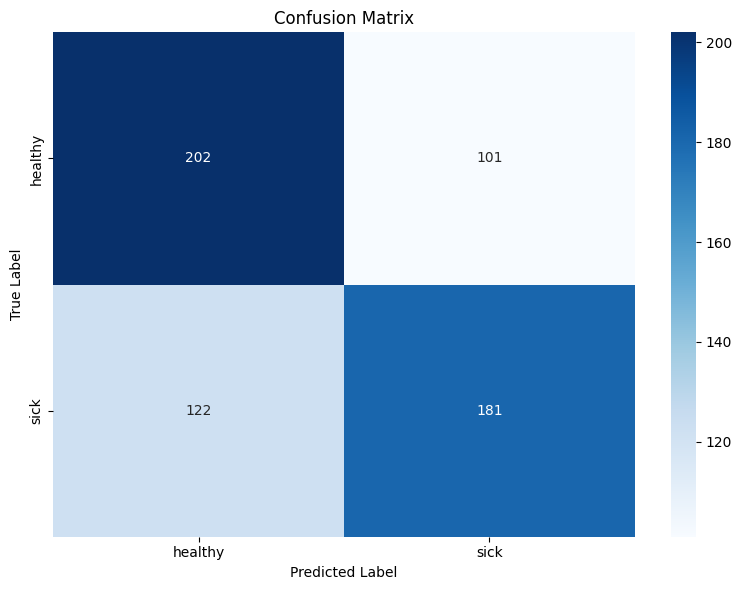

In [ ]:
#!/usr/bin/env python3
"""
Colab GPU-Optimized Robust Audio Classification Trainer
Fixes GPU/CUDA issues specifically for Google Colab
"""

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import soundfile as sf
import librosa
import warnings
import json
import datetime
from typing import List, Tuple, Dict, Optional
from pathlib import Path
import logging
from dataclasses import dataclass

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class ColabGPUConfig:
    """Colab GPU-optimized configuration"""

    # Model configuration
    SAMPLE_RATE: int = 16000
    DURATION: float = 3.0
    MAX_LENGTH: int = 48000

    # Training configuration - GPU optimized for Colab
    BATCH_SIZE: int = 4  # Small batch to avoid OOM
    EPOCHS: int = 20
    LEARNING_RATE: float = 5e-6  # Very conservative for stability

    # Data configuration
    TRAIN_SPLIT: float = 0.7
    VAL_SPLIT: float = 0.15
    TEST_SPLIT: float = 0.15

    # Bias prevention
    MAX_CLASS_IMBALANCE_RATIO: float = 3.0
    MIN_SAMPLES_PER_CLASS: int = 50

    # Audio validation
    MIN_AUDIO_LENGTH: float = 1.0
    MAX_AUDIO_LENGTH: float = 10.0

    # Augmentation
    USE_AUGMENTATION: bool = True
    AUGMENTATION_PROB: float = 0.3

    # Directory configuration
    BASE_DIR: str = '/content/smartearsaudio/sm'
    HEALTHY_DIR: str = '/content/smartearsaudio/sm/Healthy'
    SICK_DIR: str = '/content/smartearsaudio/sm/Sick'
    NOISE_DIR: str = '/content/smartearsaudio/sm/noise'
    OUTPUT_DIR: str = './colab_gpu_model_output'


def fix_colab_gpu():
    """Fix GPU issues specific to Google Colab"""
    logger.info("🔧 Fixing Colab GPU configuration...")

    # Clear any existing TF state
    tf.keras.backend.clear_session()

    # Reset TensorFlow
    try:
        tf.config.experimental.reset_memory_growth_v2()
    except:
        pass

    # Configure GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth for all GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set a reasonable memory limit (adjust based on your Colab GPU)
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]  # 8GB limit
            )

            logger.info(f"✅ GPU configured: {len(gpus)} GPU(s) available")

        except RuntimeError as e:
            logger.warning(f"GPU configuration warning: {e}")
    else:
        logger.warning("⚠️ No GPU detected")

    # Disable mixed precision to avoid type issues
    tf.keras.mixed_precision.set_global_policy('float32')

    # Set TensorFlow to use deterministic operations with seed
    tf.config.experimental.enable_op_determinism()
    tf.random.set_seed(42)  # Set seed for deterministic operations

    logger.info("✅ Colab GPU configuration complete")


class ColabAudioProcessor:
    """Colab-optimized audio processing"""

    def __init__(self, config: ColabGPUConfig):
        self.config = config

    def validate_audio_file(self, file_path: str) -> Tuple[bool, str]:
        """Validate audio file"""
        try:
            if not os.path.exists(file_path):
                return False, "File does not exist"

            if os.path.getsize(file_path) < 1000:
                return False, "File too small"

            # Load and check basic properties
            try:
                waveform, sr = librosa.load(file_path, sr=None, mono=True)
            except Exception as e:
                return False, f"Cannot load audio: {e}"

            duration = len(waveform) / sr
            if duration < self.config.MIN_AUDIO_LENGTH:
                return False, f"Audio too short: {duration:.2f}s"
            if duration > self.config.MAX_AUDIO_LENGTH:
                return False, f"Audio too long: {duration:.2f}s"

            if np.std(waveform) < 1e-6:
                return False, "Audio is silent"

            if not np.isfinite(waveform).all():
                return False, "Audio contains NaN/Inf"

            return True, "Valid"

        except Exception as e:
            return False, f"Validation error: {e}"

    def load_and_preprocess_audio(self, file_path: str) -> Optional[np.ndarray]:
        """Load and preprocess audio with Colab-specific fixes"""
        try:
            is_valid, reason = self.validate_audio_file(file_path)
            if not is_valid:
                return None

            # Load audio with fallback for resampling issues
            try:
                waveform, sr = librosa.load(
                    file_path,
                    sr=self.config.SAMPLE_RATE,
                    mono=True,
                    res_type='scipy'  # Use scipy instead of resampy
                )
            except Exception as e:
                if 'resampy' in str(e) or 'res_type' in str(e):
                    # Fallback without resampling
                    waveform, original_sr = librosa.load(file_path, sr=None, mono=True)
                    if original_sr != self.config.SAMPLE_RATE:
                        waveform = self._scipy_resample(waveform, original_sr, self.config.SAMPLE_RATE)
                else:
                    return None

            # Handle length
            target_length = self.config.MAX_LENGTH

            if len(waveform) > target_length:
                # Take center portion
                start = (len(waveform) - target_length) // 2
                waveform = waveform[start:start + target_length]
            elif len(waveform) < target_length:
                # Pad with zeros
                waveform = np.pad(waveform, (0, target_length - len(waveform)), 'constant')

            # Normalize
            waveform = self._normalize_audio(waveform)

            if not np.isfinite(waveform).all():
                return None

            return waveform.astype(np.float32)

        except Exception as e:
            logger.debug(f"Error processing {file_path}: {e}")
            return None

    def _scipy_resample(self, waveform: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
        """Resample using scipy"""
        try:
            from scipy import signal
            if orig_sr == target_sr:
                return waveform

            ratio = target_sr / orig_sr
            new_length = int(len(waveform) * ratio)
            resampled = signal.resample(waveform, new_length)
            return resampled.astype(np.float32)

        except ImportError:
            # Fallback to linear interpolation
            ratio = target_sr / orig_sr
            new_length = int(len(waveform) * ratio)
            old_indices = np.linspace(0, len(waveform) - 1, len(waveform))
            new_indices = np.linspace(0, len(waveform) - 1, new_length)
            resampled = np.interp(new_indices, old_indices, waveform)
            return resampled.astype(np.float32)

    def _normalize_audio(self, waveform: np.ndarray) -> np.ndarray:
        """Robust normalization"""
        try:
            # Remove DC offset
            waveform = waveform - np.mean(waveform)

            # Scale using 99th percentile
            p99 = np.percentile(np.abs(waveform), 99)
            if p99 > 1e-8:
                waveform = waveform / p99 * 0.8

            # Clip to prevent extreme values
            waveform = np.clip(waveform, -1.0, 1.0)

            return waveform

        except Exception:
            return np.zeros_like(waveform)

    def apply_augmentation(self, waveform: np.ndarray) -> np.ndarray:
        """Light augmentation"""
        if not self.config.USE_AUGMENTATION:
            return waveform

        try:
            augmented = waveform.copy()

            # Time shifting
            if np.random.random() < self.config.AUGMENTATION_PROB:
                shift = int(np.random.uniform(-0.05, 0.05) * len(augmented))
                augmented = np.roll(augmented, shift)

            # Volume scaling
            if np.random.random() < self.config.AUGMENTATION_PROB:
                scale = np.random.uniform(0.8, 1.2)
                augmented = augmented * scale

            # Add noise
            if np.random.random() < self.config.AUGMENTATION_PROB * 0.5:
                noise_level = np.random.uniform(0.001, 0.005)
                noise = np.random.normal(0, noise_level, len(augmented))
                augmented = augmented + noise

            augmented = np.clip(augmented, -1.0, 1.0)

            if not np.isfinite(augmented).all():
                return waveform

            return augmented

        except Exception:
            return waveform

    def extract_features(self, waveform: np.ndarray) -> np.ndarray:
        """Extract mel spectrogram features"""
        try:
            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=waveform,
                sr=self.config.SAMPLE_RATE,
                n_mels=80,
                hop_length=512,
                n_fft=1024
            )

            # Convert to log scale
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)

            # Flatten and pad/truncate to fixed size
            features = log_mel.flatten()
            target_size = 800  # Fixed feature size

            if len(features) > target_size:
                features = features[:target_size]
            else:
                features = np.pad(features, (0, target_size - len(features)), 'constant')

            return features.astype(np.float32)

        except Exception as e:
            logger.error(f"Feature extraction failed: {e}")
            return np.zeros(800, dtype=np.float32)


class ColabDatasetBuilder:
    """Colab-optimized dataset builder"""

    def __init__(self, config: ColabGPUConfig):
        self.config = config
        self.processor = ColabAudioProcessor(config)

    def collect_and_balance_data(self) -> Tuple[List[str], List[int], List[str]]:
        """Collect and balance dataset"""
        logger.info("Collecting and balancing dataset...")

        # Collect files
        healthy_files = self._collect_files(self.config.HEALTHY_DIR, "healthy")
        sick_files = self._collect_files(self.config.SICK_DIR, "sick")

        logger.info(f"Raw counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}")

        # Validate files
        healthy_files = self._validate_files(healthy_files, "healthy")
        sick_files = self._validate_files(sick_files, "sick")

        logger.info(f"Valid counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}")

        # Check minimum requirements
        if len(healthy_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient healthy samples: {len(healthy_files)}")
        if len(sick_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient sick samples: {len(sick_files)}")

        # Balance classes
        healthy_files, sick_files = self._balance_classes(healthy_files, sick_files)

        # Create final dataset
        all_files = healthy_files + sick_files
        all_labels = [0] * len(healthy_files) + [1] * len(sick_files)
        class_names = ['healthy', 'sick']

        logger.info(f"Final dataset - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}")

        return all_files, all_labels, class_names

    def _collect_files(self, directory: str, category: str) -> List[str]:
        """Collect audio files"""
        files = []
        if os.path.exists(directory):
            for ext in ['.wav', '.mp3', '.flac']:
                files.extend(Path(directory).rglob(f'*{ext}'))
        return [str(f) for f in files]

    def _validate_files(self, files: List[str], category: str) -> List[str]:
        """Validate audio files"""
        valid_files = []

        logger.info(f"Validating {len(files)} {category} files...")

        for file_path in tqdm(files, desc=f"Validating {category}"):
            is_valid, reason = self.processor.validate_audio_file(file_path)
            if is_valid:
                valid_files.append(file_path)

        return valid_files

    def _balance_classes(self, healthy_files: List[str], sick_files: List[str]) -> Tuple[List[str], List[str]]:
        """Balance classes to prevent bias"""
        counts = [len(healthy_files), len(sick_files)]
        min_count = min(counts)
        max_count = max(counts)

        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        if imbalance_ratio > self.config.MAX_CLASS_IMBALANCE_RATIO:
            logger.info(f"Balancing classes (ratio: {imbalance_ratio:.2f})")
            target_size = min_count

            if len(healthy_files) > target_size:
                healthy_files = np.random.choice(healthy_files, target_size, replace=False).tolist()
            if len(sick_files) > target_size:
                sick_files = np.random.choice(sick_files, target_size, replace=False).tolist()

        return healthy_files, sick_files


class ColabGPUTrainer:
    """Colab GPU-optimized trainer"""

    def __init__(self, config: ColabGPUConfig):
        self.config = config
        self.processor = ColabAudioProcessor(config)

        os.makedirs(config.OUTPUT_DIR, exist_ok=True)

        # Fix GPU configuration
        fix_colab_gpu()

    def create_dataset(self, file_paths: List[str], labels: List[int], is_training: bool = True) -> tf.data.Dataset:
        """Create GPU-optimized dataset"""

        def load_audio_tf(file_path, label):
            def load_and_process(path):
                path_str = path.numpy().decode('utf-8')
                waveform = self.processor.load_and_preprocess_audio(path_str)

                if waveform is None:
                    waveform = np.zeros(self.config.MAX_LENGTH, dtype=np.float32)
                else:
                    if is_training:
                        waveform = self.processor.apply_augmentation(waveform)

                # Extract features
                features = self.processor.extract_features(waveform)
                return features

            audio_data = tf.py_function(
                load_and_process,
                inp=[file_path],
                Tout=tf.float32
            )
            audio_data.set_shape([800])  # Fixed feature size

            return audio_data, label

        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        if is_training:
            dataset = dataset.shuffle(buffer_size=min(1000, len(file_paths)))

        dataset = dataset.map(load_audio_tf, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.filter(lambda audio, label: tf.reduce_all(tf.math.is_finite(audio)))
        dataset = dataset.batch(self.config.BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_model(self, num_classes: int) -> tf.keras.Model:
        """Create GPU-optimized model"""

        # Use tf.keras.utils.get_custom_objects() to avoid issues
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(800,)),

                # Dense layers with proper initialization
                tf.keras.layers.Dense(
                    512,
                    activation='relu',
                    kernel_initializer='he_normal',
                    bias_initializer='zeros'
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.3),

                tf.keras.layers.Dense(
                    256,
                    activation='relu',
                    kernel_initializer='he_normal',
                    bias_initializer='zeros'
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2),

                tf.keras.layers.Dense(
                    128,
                    activation='relu',
                    kernel_initializer='he_normal',
                    bias_initializer='zeros'
                ),
                tf.keras.layers.Dropout(0.1),

                tf.keras.layers.Dense(
                    num_classes,
                    activation='softmax',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    dtype='float32'  # Ensure float32 output
                )
            ])

        logger.info("✅ GPU model created")
        return model

    def compile_model(self, model: tf.keras.Model) -> tf.keras.Model:
        """Compile model with GPU-optimized settings"""

        # Use a very stable optimizer configuration
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7,  # Slightly larger epsilon for stability
            clipnorm=0.5   # Aggressive gradient clipping
        )

        # Simple loss function to avoid type issues
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'],
            run_eagerly=False  # Ensure graph mode for GPU efficiency
        )

        return model

    def create_callbacks(self) -> List[tf.keras.callbacks.Callback]:
        """Create training callbacks"""
        return [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(self.config.OUTPUT_DIR, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            tf.keras.callbacks.TerminateOnNaN()
        ]

    def train(self, train_dataset, val_dataset, class_weights, num_classes):
        """Train model on GPU"""
        logger.info("Creating and compiling model...")

        model = self.create_model(num_classes)
        model = self.compile_model(model)

        logger.info("Model architecture:")
        model.summary(print_fn=logger.info)

        callbacks = self.create_callbacks()

        logger.info(f"Starting GPU training for {self.config.EPOCHS} epochs...")

        try:
            # Use tf.distribute.MirroredStrategy if multiple GPUs
            strategy = tf.distribute.get_strategy()

            with strategy.scope():
                history = model.fit(
                    train_dataset,
                    epochs=self.config.EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks,
                    verbose=1,
                    class_weight=class_weights
                )

            logger.info("✅ GPU training completed successfully!")
            return model, history

        except Exception as e:
            logger.error(f"Training failed: {e}")
            raise

    def evaluate_model(self, model, test_dataset, class_names):
        """Evaluate model"""
        logger.info("Evaluating model...")

        try:
            predictions = model.predict(test_dataset, verbose=1)

            y_true = []
            for _, labels in test_dataset:
                y_true.extend(labels.numpy())
            y_true = np.array(y_true)

            y_pred = np.argmax(predictions, axis=1)

            accuracy = balanced_accuracy_score(y_true, y_pred)

            logger.info(f"Balanced Accuracy: {accuracy:.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names))

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            self._plot_confusion_matrix(cm, class_names)

            return {
                'accuracy': accuracy,
                'y_true': y_true,
                'y_pred': y_pred,
                'predictions': predictions,
                'confusion_matrix': cm
            }

        except Exception as e:
            logger.error(f"Evaluation failed: {e}")
            return {}

    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()


def main():
    """Main Colab GPU training pipeline"""
    logger.info("🚀 Starting Colab GPU-optimized audio classification...")

    config = ColabGPUConfig()

    try:
        # Build dataset
        dataset_builder = ColabDatasetBuilder(config)
        all_files, all_labels, class_names = dataset_builder.collect_and_balance_data()

        if len(all_files) == 0:
            raise ValueError("No valid audio files found!")

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            all_files, all_labels,
            test_size=config.TEST_SPLIT,
            random_state=42,
            stratify=all_labels
        )

        val_size = config.VAL_SPLIT / (1 - config.TEST_SPLIT)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            random_state=42,
            stratify=y_temp
        )

        logger.info(f"Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))
        logger.info(f"Class weights: {class_weight_dict}")

        # Create trainer
        trainer = ColabGPUTrainer(config)

        # Create datasets
        train_dataset = trainer.create_dataset(X_train, y_train, is_training=True)
        val_dataset = trainer.create_dataset(X_val, y_val, is_training=False)
        test_dataset = trainer.create_dataset(X_test, y_test, is_training=False)

        # Train model
        model, history = trainer.train(
            train_dataset, val_dataset, class_weight_dict, len(class_names)
        )

        # Evaluate model
        results = trainer.evaluate_model(model, test_dataset, class_names)

        # Save results
        model.save(os.path.join(config.OUTPUT_DIR, 'final_model.h5'))

        with open(os.path.join(config.OUTPUT_DIR, 'training_results.json'), 'w') as f:
            json.dump({
                'class_names': class_names,
                'accuracy': float(results.get('accuracy', 0)),
                'class_weights': {str(k): float(v) for k, v in class_weight_dict.items()},
                'training_mode': 'GPU',
                'timestamp': datetime.datetime.now().isoformat()
            }, f, indent=2)

        logger.info(f"🎉 GPU training completed! Results saved to {config.OUTPUT_DIR}")
        logger.info(f"📊 Final Accuracy: {results.get('accuracy', 0):.2%}")

        return model, results

    except Exception as e:
        logger.error(f"Training pipeline failed: {e}")
        raise


if __name__ == "__main__":
    model, results = main()

In [ ]:
result = predict_audio_file('/content/smartearsaudio/sm/Healthy/1.wav')
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")

NameError: name 'predict_audio_file' is not defined

In [ ]:
#!/usr/bin/env python3
"""
Quick Model Testing Script
Test your trained Colab GPU model on new audio files
"""

import os
import numpy as np
import tensorflow as tf
import librosa
import soundfile as sf
from pathlib import Path

def predict_audio_file(audio_path, model_path='./colab_gpu_model_output/best_model.h5'):
    """
    Predict chicken sound classification for a single audio file

    Args:
        audio_path: Path to the audio file to classify
        model_path: Path to the trained model

    Returns:
        Dictionary with prediction results
    """

    # Configuration (same as training)
    SAMPLE_RATE = 16000
    DURATION = 3.0
    MAX_LENGTH = int(SAMPLE_RATE * DURATION)

    try:
        # Load the trained model
        print(f"🤖 Loading model from {model_path}...")
        model = tf.keras.models.load_model(model_path)
        print("✅ Model loaded successfully!")

        # Load and preprocess audio
        print(f"🎵 Processing audio: {audio_path}")

        # Load audio file
        try:
            waveform, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
        except Exception as e:
            return {'error': f"Could not load audio file: {e}"}

        # Handle length - pad or truncate to 3 seconds
        if len(waveform) > MAX_LENGTH:
            # Take center portion
            start = (len(waveform) - MAX_LENGTH) // 2
            waveform = waveform[start:start + MAX_LENGTH]
        elif len(waveform) < MAX_LENGTH:
            # Pad with zeros
            waveform = np.pad(waveform, (0, MAX_LENGTH - len(waveform)), 'constant')

        # Normalize audio
        if np.max(np.abs(waveform)) > 0:
            waveform = waveform / np.max(np.abs(waveform)) * 0.8

        # Extract mel spectrogram features (same as training)
        mel_spec = librosa.feature.melspectrogram(
            y=waveform,
            sr=SAMPLE_RATE,
            n_mels=80,
            hop_length=512,
            n_fft=1024
        )

        # Convert to log scale
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)

        # Flatten and pad/truncate to fixed size
        features = log_mel.flatten()
        target_size = 800  # Same as training

        if len(features) > target_size:
            features = features[:target_size]
        else:
            features = np.pad(features, (0, target_size - len(features)), 'constant')

        # Prepare for prediction
        features = features.astype(np.float32)
        features = np.expand_dims(features, axis=0)  # Add batch dimension

        # Make prediction
        print("🔮 Making prediction...")
        predictions = model.predict(features, verbose=0)

        # Get probabilities and predicted class
        probabilities = predictions[0]
        predicted_class = np.argmax(probabilities)
        confidence = probabilities[predicted_class]

        # Class names
        class_names = ['healthy', 'sick']
        predicted_label = class_names[predicted_class]

        # Prepare results
        result = {
            'audio_file': audio_path,
            'prediction': predicted_label,
            'predicted_class': int(predicted_class),
            'confidence': float(confidence),
            'probabilities': {
                'healthy': float(probabilities[0]),
                'sick': float(probabilities[1])
            }
        }

        # Display results
        print(f"\n🎯 PREDICTION RESULTS:")
        print(f"   File: {os.path.basename(audio_path)}")
        print(f"   Prediction: {predicted_label.upper()}")
        print(f"   Confidence: {confidence:.2%}")
        print(f"   Probabilities:")
        print(f"     Healthy: {probabilities[0]:.2%}")
        print(f"     Sick: {probabilities[1]:.2%}")

        return result

    except Exception as e:
        error_msg = f"Prediction failed: {e}"
        print(f"❌ {error_msg}")
        return {'error': error_msg}


def test_multiple_files(directory_path, model_path='./colab_gpu_model_output/best_model.h5', limit=10):
    """
    Test the model on multiple audio files from a directory

    Args:
        directory_path: Path to directory containing audio files
        model_path: Path to the trained model
        limit: Maximum number of files to test

    Returns:
        List of prediction results
    """

    print(f"🔍 Testing model on files from: {directory_path}")

    # Find audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []

    for ext in audio_extensions:
        audio_files.extend(Path(directory_path).glob(f'*{ext}'))

    if not audio_files:
        print(f"❌ No audio files found in {directory_path}")
        return []

    # Limit number of files
    audio_files = audio_files[:limit]
    print(f"📁 Found {len(audio_files)} audio files to test")

    results = []

    for i, audio_file in enumerate(audio_files, 1):
        print(f"\n--- Testing file {i}/{len(audio_files)} ---")
        result = predict_audio_file(str(audio_file), model_path)
        results.append(result)

    # Summary
    print(f"\n📊 SUMMARY OF {len(results)} PREDICTIONS:")
    healthy_count = sum(1 for r in results if r.get('prediction') == 'healthy')
    sick_count = sum(1 for r in results if r.get('prediction') == 'sick')
    error_count = sum(1 for r in results if 'error' in r)

    print(f"   Healthy: {healthy_count}")
    print(f"   Sick: {sick_count}")
    print(f"   Errors: {error_count}")

    return results


def quick_test():
    """Quick test function with sample files"""

    # Test paths
    test_paths = [
        '/content/smartearsaudio/sm/Healthy/1.wav',
        '/content/smartearsaudio/sm/Sick/1.wav',
        '/content/smartearsaudio/sm/Healthy/rpi0008-20240428003530.wav',
        '/content/smartearsaudio/sm/Sick/rpi0007-20240801222530.wav'
    ]

    print("🚀 Quick Model Test")
    print("=" * 50)

    for test_path in test_paths:
        if os.path.exists(test_path):
            print(f"\n🎵 Testing: {test_path}")
            result = predict_audio_file(test_path)
            break
        else:
            print(f"⚠️ File not found: {test_path}")

    # Test on a few files from each directory
    print(f"\n🔍 Testing on sample files from each class...")

    healthy_dir = '/content/smartearsaudio/sm/Healthy'
    sick_dir = '/content/smartearsaudio/sm/Sick'

    if os.path.exists(healthy_dir):
        print(f"\n--- HEALTHY SAMPLES ---")
        test_multiple_files(healthy_dir, limit=3)

    if os.path.exists(sick_dir):
        print(f"\n--- SICK SAMPLES ---")
        test_multiple_files(sick_dir, limit=3)


if __name__ == "__main__":
    quick_test()

🚀 Quick Model Test

🎵 Testing: /content/smartearsaudio/sm/Healthy/1.wav
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...


✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Healthy/1.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: 1.wav
   Prediction: HEALTHY
   Confidence: 61.05%
   Probabilities:
     Healthy: 61.05%
     Sick: 38.95%

🔍 Testing on sample files from each class...

--- HEALTHY SAMPLES ---
🔍 Testing model on files from: /content/smartearsaudio/sm/Healthy
📁 Found 3 audio files to test

--- Testing file 1/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Healthy/rpi0016-20241126011900.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: rpi0016-20241126011900.wav
   Prediction: HEALTHY
   Confidence: 97.91%
   Probabilities:
     Healthy: 97.91%
     Sick: 2.09%

--- Testing file 2/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Healthy/rpi0013-20240505220030.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: rpi0013-20240505220030.wav
   Prediction: SICK
   Confidence: 69.62%
   Probabilities:
     Healthy: 30.38%
     Sick: 69.62%

--- Testing file 3/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Healthy/rpi0013-20240331100000.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: rpi0013-20240331100000.wav
   Prediction: HEALTHY
   Confidence: 83.77%
   Probabilities:
     Healthy: 83.77%
     Sick: 16.23%

📊 SUMMARY OF 3 PREDICTIONS:
   Healthy: 2
   Sick: 1
   Errors: 0

--- SICK SAMPLES ---
🔍 Testing model on files from: /content/smartearsaudio/sm/Sick
📁 Found 3 audio files to test

--- Testing file 1/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Sick/rpi0106-20240406141200-0.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: rpi0106-20240406141200-0.wav
   Prediction: SICK
   Confidence: 70.19%
   Probabilities:
     Healthy: 29.81%
     Sick: 70.19%

--- Testing file 2/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Sick/rpi0012-20240306222330.wav
🔮 Making prediction...



🎯 PREDICTION RESULTS:
   File: rpi0012-20240306222330.wav
   Prediction: HEALTHY
   Confidence: 50.53%
   Probabilities:
     Healthy: 50.53%
     Sick: 49.47%

--- Testing file 3/3 ---
🤖 Loading model from ./colab_gpu_model_output/best_model.h5...
✅ Model loaded successfully!
🎵 Processing audio: /content/smartearsaudio/sm/Sick/20.wav
🔮 Making prediction...

🎯 PREDICTION RESULTS:
   File: 20.wav
   Prediction: SICK
   Confidence: 93.52%
   Probabilities:
     Healthy: 6.48%
     Sick: 93.52%

📊 SUMMARY OF 3 PREDICTIONS:
   Healthy: 1
   Sick: 2
   Errors: 0


Validating healthy:   0%|          | 0/2139 [00:00<?, ?it/s]

Validating sick:   0%|          | 0/2121 [00:00<?, ?it/s]

Validating noise: 0it [00:00, ?it/s]

Epoch 1/20
    353/Unknown 192s 536ms/step - accuracy: 0.5475 - loss: 0.1125
Epoch 1: val_accuracy improved from -inf to 0.61983, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 237s 663ms/step - accuracy: 0.5476 - loss: 0.1125 - val_accuracy: 0.6198 - val_loss: 0.0645 - learning_rate: 1.0000e-05
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6468 - loss: 0.0774
Epoch 2: val_accuracy improved from 0.61983 to 0.64959, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 258s 654ms/step - accuracy: 0.6468 - loss: 0.0774 - val_accuracy: 0.6496 - val_loss: 0.0615 - learning_rate: 1.0000e-05
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7229 - loss: 0.0649
Epoch 3: val_accuracy improved from 0.64959 to 0.66116, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 260s 649ms/step - accuracy: 0.7229 - loss: 0.0648 - val_accuracy: 0.6612 - val_loss: 0.0601 - learning_rate: 1.0000e-05
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7604 - loss: 0.0505
Epoch 4: val_accuracy improved from 0.66116 to 0.67107, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 333s 850ms/step - accuracy: 0.7604 - loss: 0.0505 - val_accuracy: 0.6711 - val_loss: 0.0656 - learning_rate: 1.0000e-05
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7760 - loss: 0.0457
Epoch 5: val_accuracy improved from 0.67107 to 0.69256, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 249s 707ms/step - accuracy: 0.7760 - loss: 0.0457 - val_accuracy: 0.6926 - val_loss: 0.0620 - learning_rate: 1.0000e-05
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7934 - loss: 0.0462
Epoch 6: val_accuracy improved from 0.69256 to 0.69752, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 239s 643ms/step - accuracy: 0.7934 - loss: 0.0462 - val_accuracy: 0.6975 - val_loss: 0.0644 - learning_rate: 1.0000e-05
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8244 - loss: 0.0411
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 7: val_accuracy improved from 0.69752 to 0.70083, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 267s 657ms/step - accuracy: 0.8244 - loss: 0.0411 - val_accuracy: 0.7008 - val_loss: 0.0676 - learning_rate: 1.0000e-05
Epoch 8/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8446 - loss: 0.0375
Epoch 8: val_accuracy improved from 0.70083 to 0.72231, saving model to ./robust_model_output/best_model.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 227s 644ms/step - accuracy: 0.8446 - loss: 0.0375 - val_accuracy: 0.7223 - val_loss: 0.0651 - learning_rate: 5.0000e-06
Epoch 9/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8319 - loss: 0.0359
Epoch 9: val_accuracy did not improve from 0.72231
353/353 ━━━━━━━━━━━━━━━━━━━━ 260s 637ms/step - accuracy: 0.8319 - loss: 0.0359 - val_accuracy: 0.7140 - val_loss: 0.0628 - learning_rate: 5.0000e-06
Epoch 10/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8594 - loss: 0.0306
Epoch 10: val_accuracy did not improve from 0.72231
353/353 ━━━━━━━━━━━━━━━━━━━━ 262s 742ms/step - accuracy: 0.8593 - loss: 0.0306 - val_accuracy: 0.7091 - val_loss: 0.0645 - learning_rate: 5.0000e-06
Epoch 11/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8417 - loss: 0.0370
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 11: val_accuracy did not improve from 0.72231
353/353 ━━━━━━━━━━━━━━━━━━━━ 263s 744ms/step - accurac

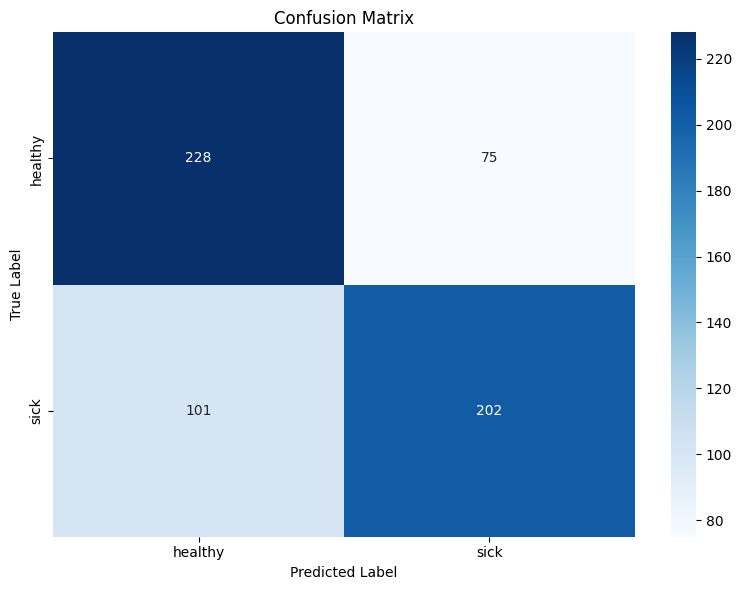

In [ ]:
#!/usr/bin/env python3
"""
Robust Wav2Vec2 Audio Classification Trainer - Fixed Version
Addresses bias, NaN losses, and compatibility issues
"""

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import soundfile as sf
import librosa
import warnings
import json
import datetime
from typing import List, Tuple, Dict, Optional, Union
import pandas as pd
from pathlib import Path
import logging
from dataclasses import dataclass
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class RobustConfig:
    """Robust configuration with bias prevention measures"""

    # Model configuration
    MODEL_ID: str = "facebook/wav2vec2-base-960h"
    SAMPLE_RATE: int = 16000
    DURATION: float = 3.0  # Reduced for better memory management
    MAX_LENGTH: int = 48000  # 3 seconds at 16kHz

    # Training configuration - Conservative settings to prevent NaN
    BATCH_SIZE: int = 8  # Smaller batch size for stability
    EPOCHS: int = 20
    LEARNING_RATE: float = 1e-5  # Much lower learning rate
    WARMUP_RATIO: float = 0.1
    WEIGHT_DECAY: float = 0.01
    GRADIENT_CLIP_NORM: float = 1.0  # Gradient clipping to prevent explosion

    # Data configuration
    TRAIN_SPLIT: float = 0.7
    VAL_SPLIT: float = 0.15
    TEST_SPLIT: float = 0.15

    # Bias prevention configuration
    MAX_CLASS_IMBALANCE_RATIO: float = 3.0  # Max ratio between largest and smallest class
    MIN_SAMPLES_PER_CLASS: int = 50  # Minimum samples required per class
    SYNTHETIC_NOISE_RATIO: float = 0.3  # Max 30% synthetic noise in dataset

    # Audio validation configuration
    MIN_AUDIO_LENGTH: float = 1.0  # Minimum 1 second
    MAX_AUDIO_LENGTH: float = 10.0  # Maximum 10 seconds
    MIN_SNR_DB: float = 5.0  # Minimum signal-to-noise ratio

    # Augmentation configuration - Reduced to prevent overfitting
    USE_AUGMENTATION: bool = True
    AUGMENTATION_PROB: float = 0.3  # Reduced probability

    # Directory configuration
    BASE_DIR: str = './data'
    HEALTHY_DIR: str = './data/healthy'
    SICK_DIR: str = './data/sick'
    NOISE_DIR: str = './data/noise'
    OUTPUT_DIR: str = './robust_model_output'

    def __post_init__(self):
        """Validate configuration"""
        assert self.TRAIN_SPLIT + self.VAL_SPLIT + self.TEST_SPLIT == 1.0
        assert self.MAX_CLASS_IMBALANCE_RATIO >= 1.0
        assert self.MIN_SAMPLES_PER_CLASS > 0
        assert 0 < self.SYNTHETIC_NOISE_RATIO < 1.0


class AudioValidator:
    """Robust audio validation to prevent NaN issues"""

    def __init__(self, config: RobustConfig):
        self.config = config

    def validate_audio_file(self, file_path: str) -> Tuple[bool, str]:
        """Comprehensive audio file validation"""
        try:
            if not os.path.exists(file_path):
                return False, "File does not exist"

            if os.path.getsize(file_path) < 1000:  # Less than 1KB
                return False, "File too small"

            # Load audio and check basic properties
            try:
                waveform, sr = librosa.load(file_path, sr=None, mono=True)
            except Exception as e:
                return False, f"Cannot load audio: {e}"

            # Check duration
            duration = len(waveform) / sr
            if duration < self.config.MIN_AUDIO_LENGTH:
                return False, f"Audio too short: {duration:.2f}s"
            if duration > self.config.MAX_AUDIO_LENGTH:
                return False, f"Audio too long: {duration:.2f}s"

            # Check for silence or constant values
            if np.std(waveform) < 1e-6:
                return False, "Audio is silent or constant"

            # Check for clipping
            clipping_ratio = np.mean(np.abs(waveform) > 0.95)
            if clipping_ratio > 0.1:
                return False, f"Audio heavily clipped: {clipping_ratio:.2%}"

            # Check signal-to-noise ratio (rough estimate)
            signal_power = np.mean(waveform ** 2)
            if signal_power < 1e-8:
                return False, "Signal power too low"

            # Check for NaN or infinite values
            if not np.isfinite(waveform).all():
                return False, "Audio contains NaN or infinite values"

            return True, "Valid"

        except Exception as e:
            return False, f"Validation error: {e}"


class RobustAudioProcessor:
    """Robust audio processing with NaN prevention"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.validator = AudioValidator(config)

        # Initialize feature extractor
        try:
            from transformers import AutoFeatureExtractor
            self.feature_extractor = AutoFeatureExtractor.from_pretrained(config.MODEL_ID)
            logger.info("✅ Feature extractor loaded successfully")
        except Exception as e:
            logger.warning(f"Could not load feature extractor: {e}")
            self.feature_extractor = None

    def load_and_preprocess_audio(self, file_path: str) -> Optional[np.ndarray]:
        """Load and preprocess audio with robust error handling"""
        try:
            # Validate file first
            is_valid, reason = self.validator.validate_audio_file(file_path)
            if not is_valid:
                logger.warning(f"Invalid audio {file_path}: {reason}")
                return None

            # Load audio with fallback resampling
            try:
                waveform, sr = librosa.load(
                    file_path,
                    sr=self.config.SAMPLE_RATE,
                    mono=True,
                    res_type='kaiser_fast'
                )
            except Exception as e:
                if 'resampy' in str(e):
                    # Fallback: load without resampling, then resample manually
                    logger.debug(f"Using fallback resampling for {file_path}")
                    waveform, original_sr = librosa.load(file_path, sr=None, mono=True)
                    if original_sr != self.config.SAMPLE_RATE:
                        waveform = self._manual_resample(waveform, original_sr, self.config.SAMPLE_RATE)
                else:
                    raise e

            # Handle length - intelligent cropping/padding
            target_length = self.config.MAX_LENGTH

            if len(waveform) > target_length:
                # For longer audio, take the most energetic segment
                hop_length = len(waveform) - target_length
                if hop_length > 0:
                    # Find the segment with highest energy
                    energies = []
                    for i in range(0, hop_length + 1, hop_length // 10 + 1):
                        segment = waveform[i:i + target_length]
                        energy = np.sum(segment ** 2)
                        energies.append((energy, i))

                    best_start = max(energies)[1]
                    waveform = waveform[best_start:best_start + target_length]
                else:
                    waveform = waveform[:target_length]

            elif len(waveform) < target_length:
                # Pad with reflection to avoid discontinuities
                pad_length = target_length - len(waveform)
                if len(waveform) > pad_length:
                    # Reflect the signal
                    waveform = np.pad(waveform, (0, pad_length), 'reflect')
                else:
                    # Zero pad if signal is too short for reflection
                    waveform = np.pad(waveform, (0, pad_length), 'constant')

            # Robust normalization
            waveform = self._robust_normalize(waveform)

            # Final validation
            if not np.isfinite(waveform).all():
                logger.warning(f"NaN/Inf detected in processed audio: {file_path}")
                return None

            return waveform.astype(np.float32)

        except Exception as e:
            logger.error(f"Error processing {file_path}: {e}")
            return None

    def _robust_normalize(self, waveform: np.ndarray) -> np.ndarray:
        """Robust normalization that prevents NaN"""
        try:
            # Remove DC offset
            waveform = waveform - np.mean(waveform)

            # Robust scaling using percentiles instead of max
            p99 = np.percentile(np.abs(waveform), 99)
            if p99 > 1e-8:
                waveform = waveform / p99 * 0.8  # Scale to 80% to avoid clipping

            # Clip to prevent extreme values
            waveform = np.clip(waveform, -1.0, 1.0)

            return waveform

        except Exception as e:
            logger.error(f"Normalization error: {e}")
            return np.zeros_like(waveform)

    def apply_augmentation(self, waveform: np.ndarray) -> np.ndarray:
        """Conservative augmentation to prevent overfitting"""
        if not self.config.USE_AUGMENTATION:
            return waveform

        try:
            augmented = waveform.copy()

            # Time shifting (small)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                shift = int(np.random.uniform(-0.05, 0.05) * len(augmented))
                augmented = np.roll(augmented, shift)

            # Volume scaling (conservative)
            if np.random.random() < self.config.AUGMENTATION_PROB:
                scale = np.random.uniform(0.8, 1.2)
                augmented = augmented * scale

            # Add small amount of noise
            if np.random.random() < self.config.AUGMENTATION_PROB * 0.5:
                noise_level = np.random.uniform(0.001, 0.005)
                noise = np.random.normal(0, noise_level, len(augmented))
                augmented = augmented + noise

            # Ensure no clipping or NaN
            augmented = np.clip(augmented, -1.0, 1.0)

            if not np.isfinite(augmented).all():
                return waveform  # Return original if augmentation failed

            return augmented

        except Exception as e:
            logger.warning(f"Augmentation failed: {e}")
            return waveform

    def extract_features(self, waveform: np.ndarray) -> np.ndarray:
        """Extract features using transformers or fallback to manual extraction"""
        try:
            if self.feature_extractor is not None:
                # Use transformers feature extractor
                inputs = self.feature_extractor(
                    waveform,
                    sampling_rate=self.config.SAMPLE_RATE,
                    return_tensors="np",
                    padding=True,
                    max_length=self.config.MAX_LENGTH,
                    truncation=True
                )
                return inputs['input_values'][0]
            else:
                # Fallback to manual feature extraction
                return self._manual_feature_extraction(waveform)

        except Exception as e:
            logger.warning(f"Feature extraction failed, using fallback: {e}")
            return self._manual_feature_extraction(waveform)

    def _manual_resample(self, waveform: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
        """Manual resampling when resampy is not available"""
        try:
            from scipy import signal
            # Calculate resampling ratio
            ratio = target_sr / orig_sr

            if ratio == 1.0:
                return waveform

            # Use scipy's resample for basic resampling
            new_length = int(len(waveform) * ratio)
            resampled = signal.resample(waveform, new_length)

            return resampled.astype(np.float32)

        except ImportError:
            # If scipy is also not available, use simple linear interpolation
            logger.warning("Using basic linear interpolation for resampling")
            ratio = target_sr / orig_sr
            new_length = int(len(waveform) * ratio)

            # Simple linear interpolation
            old_indices = np.linspace(0, len(waveform) - 1, len(waveform))
            new_indices = np.linspace(0, len(waveform) - 1, new_length)
            resampled = np.interp(new_indices, old_indices, waveform)

            return resampled.astype(np.float32)

    def _manual_feature_extraction(self, waveform: np.ndarray) -> np.ndarray:
        """Manual feature extraction as fallback"""
        try:
            # Simple spectral features
            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=waveform,
                sr=self.config.SAMPLE_RATE,
                n_mels=80,
                hop_length=512,
                n_fft=1024
            )

            # Convert to log scale
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)

            # Flatten and pad/truncate to fixed size
            features = log_mel.flatten()
            target_size = 1000  # Fixed feature size

            if len(features) > target_size:
                features = features[:target_size]
            else:
                features = np.pad(features, (0, target_size - len(features)), 'constant')

            return features.astype(np.float32)

        except Exception as e:
            logger.error(f"Manual feature extraction failed: {e}")
            # Return zeros as last resort
            return np.zeros(1000, dtype=np.float32)


class BiasPreventionDatasetBuilder:
    """Dataset builder with bias prevention measures"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

    def collect_and_balance_data(self) -> Tuple[List[str], List[int], List[str]]:
        """Collect data with bias prevention"""
        logger.info("Collecting and balancing dataset...")

        # Collect files by category
        healthy_files = self._collect_files(self.config.HEALTHY_DIR, "healthy")
        sick_files = self._collect_files(self.config.SICK_DIR, "sick")
        noise_files = self._collect_files(self.config.NOISE_DIR, "noise")

        logger.info(f"Raw file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Validate files
        healthy_files = self._validate_files(healthy_files, "healthy")
        sick_files = self._validate_files(sick_files, "sick")
        noise_files = self._validate_files(noise_files, "noise")

        logger.info(f"Valid file counts - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        # Check minimum requirements
        if len(healthy_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient healthy samples: {len(healthy_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")
        if len(sick_files) < self.config.MIN_SAMPLES_PER_CLASS:
            raise ValueError(f"Insufficient sick samples: {len(sick_files)} < {self.config.MIN_SAMPLES_PER_CLASS}")

        # Balance dataset to prevent bias
        healthy_files, sick_files, noise_files = self._balance_classes(
            healthy_files, sick_files, noise_files
        )

        # Determine class configuration
        if len(noise_files) > 0:
            all_files = healthy_files + sick_files + noise_files
            all_labels = ([0] * len(healthy_files) +
                         [1] * len(sick_files) +
                         [2] * len(noise_files))
            class_names = ['healthy', 'sick', 'noise']
        else:
            all_files = healthy_files + sick_files
            all_labels = [0] * len(healthy_files) + [1] * len(sick_files)
            class_names = ['healthy', 'sick']

        logger.info(f"Final balanced dataset - Classes: {class_names}")
        for i, name in enumerate(class_names):
            count = sum(1 for label in all_labels if label == i)
            logger.info(f"  {name}: {count} samples")

        return all_files, all_labels, class_names

    def _collect_files(self, directory: str, category: str) -> List[str]:
        """Collect audio files from directory"""
        files = []
        if os.path.exists(directory):
            for ext in ['.wav', '.mp3', '.flac', '.m4a']:
                files.extend(Path(directory).rglob(f'*{ext}'))

        return [str(f) for f in files]

    def _validate_files(self, files: List[str], category: str) -> List[str]:
        """Validate audio files"""
        valid_files = []

        logger.info(f"Validating {len(files)} {category} files...")

        for file_path in tqdm(files, desc=f"Validating {category}"):
            is_valid, reason = self.processor.validator.validate_audio_file(file_path)
            if is_valid:
                valid_files.append(file_path)
            else:
                logger.debug(f"Rejected {file_path}: {reason}")

        rejection_rate = (len(files) - len(valid_files)) / len(files) if files else 0
        logger.info(f"{category} validation: {len(valid_files)}/{len(files)} valid ({rejection_rate:.1%} rejected)")

        return valid_files

    def _balance_classes(self, healthy_files: List[str], sick_files: List[str],
                        noise_files: List[str]) -> Tuple[List[str], List[str], List[str]]:
        """Balance classes to prevent bias"""

        # Calculate target sizes
        counts = [len(healthy_files), len(sick_files)]
        if noise_files:
            counts.append(len(noise_files))

        min_count = min(counts)
        max_count = max(counts)

        # Check if balancing is needed
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        if imbalance_ratio > self.config.MAX_CLASS_IMBALANCE_RATIO:
            logger.info(f"Balancing classes (ratio: {imbalance_ratio:.2f} > {self.config.MAX_CLASS_IMBALANCE_RATIO})")

            # Calculate target size (use median to avoid extreme reduction)
            target_size = int(np.median(counts))

            # Limit noise files to prevent overwhelming real data
            if noise_files:
                max_noise = int(target_size * self.config.SYNTHETIC_NOISE_RATIO / (1 - self.config.SYNTHETIC_NOISE_RATIO))
                if len(noise_files) > max_noise:
                    noise_files = np.random.choice(noise_files, max_noise, replace=False).tolist()
                    logger.info(f"Limited noise files to {max_noise}")

            # Balance healthy and sick files
            if len(healthy_files) > target_size:
                healthy_files = np.random.choice(healthy_files, target_size, replace=False).tolist()
            if len(sick_files) > target_size:
                sick_files = np.random.choice(sick_files, target_size, replace=False).tolist()

        logger.info(f"Balanced dataset - Healthy: {len(healthy_files)}, Sick: {len(sick_files)}, Noise: {len(noise_files)}")

        return healthy_files, sick_files, noise_files


class SimpleRobustTrainer:
    """Simplified robust trainer with better compatibility"""

    def __init__(self, config: RobustConfig):
        self.config = config
        self.processor = RobustAudioProcessor(config)

        # Setup directories
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)

        # Configure TensorFlow for stability
        self._configure_tensorflow()

    def _configure_tensorflow(self):
        """Configure TensorFlow for stable training"""
        # Disable mixed precision to avoid type issues
        tf.keras.mixed_precision.set_global_policy('float32')

        # Configure GPU memory growth
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logger.info("✅ GPU memory growth enabled")
            except RuntimeError as e:
                logger.warning(f"GPU configuration warning: {e}")

    def create_dataset(self, file_paths: List[str], labels: List[int],
                      is_training: bool = True) -> tf.data.Dataset:
        """Create robust TensorFlow dataset"""

        def load_audio_tf(file_path, label):
            def load_and_process(path):
                path_str = path.numpy().decode('utf-8')
                waveform = self.processor.load_and_preprocess_audio(path_str)

                if waveform is None:
                    # Return zeros if loading failed
                    waveform = np.zeros(self.config.MAX_LENGTH, dtype=np.float32)
                else:
                    # Apply augmentation for training
                    if is_training:
                        waveform = self.processor.apply_augmentation(waveform)

                # Extract features
                features = self.processor.extract_features(waveform)
                return features

            audio_data = tf.py_function(
                load_and_process,
                inp=[file_path],
                Tout=tf.float32
            )

            # Set shape based on feature extraction method
            if self.processor.feature_extractor is not None:
                audio_data.set_shape([self.config.MAX_LENGTH])
            else:
                audio_data.set_shape([1000])  # Manual feature size

            return audio_data, label

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        if is_training:
            dataset = dataset.shuffle(buffer_size=min(1000, len(file_paths)))

        dataset = dataset.map(
            load_audio_tf,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Filter out any invalid samples
        dataset = dataset.filter(
            lambda audio, label: tf.reduce_all(tf.math.is_finite(audio))
        )

        dataset = dataset.batch(self.config.BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_simple_model(self, num_classes: int, input_shape: Tuple[int]):
        """Create a simple, robust model"""
        try:
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=input_shape),

                # If using raw audio, add some conv layers
                tf.keras.layers.Reshape((-1, 1)) if len(input_shape) == 1 and input_shape[0] > 1000 else tf.keras.layers.Lambda(lambda x: x),

                # Dense layers for classification
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])

            logger.info("✅ Simple model created successfully")
            return model

        except Exception as e:
            logger.error(f"Model creation failed: {e}")
            raise

    def compile_model(self, model, class_weights: Dict[int, float]):
        """Compile model with robust settings"""

        # Use a stable optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8,
            clipnorm=self.config.GRADIENT_CLIP_NORM
        )

        # Use focal loss to handle class imbalance with proper type handling
        def focal_loss(alpha=0.25, gamma=2.0):
            def focal_loss_fixed(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()

                # Ensure consistent dtypes - cast everything to float32
                y_pred = tf.cast(y_pred, tf.float32)
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Convert to one-hot if needed and ensure float32
                if len(y_true.shape) == 1:
                    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])
                y_true = tf.cast(y_true, tf.float32)

                # Calculate focal loss with consistent types
                ce = -y_true * tf.math.log(y_pred)
                weight = tf.cast(alpha, tf.float32) * y_true * tf.pow((1 - y_pred), tf.cast(gamma, tf.float32))
                fl = weight * ce

                return tf.reduce_mean(tf.reduce_sum(fl, axis=1))

            return focal_loss_fixed

        model.compile(
            optimizer=optimizer,
            loss=focal_loss(),
            metrics=['accuracy']
        )

        return model

    def create_callbacks(self):
        """Create training callbacks for stability"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(self.config.OUTPUT_DIR, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            # NaN termination callback
            tf.keras.callbacks.TerminateOnNaN(),
            # Custom callback for monitoring
            RobustTrainingCallback()
        ]

        return callbacks

    def train(self, train_dataset, val_dataset, class_weights, num_classes):
        """Train model with robust settings"""

        logger.info("Creating and compiling model...")

        # Determine input shape from dataset
        sample_batch = next(iter(train_dataset))
        input_shape = sample_batch[0].shape[1:]
        logger.info(f"Input shape: {input_shape}")

        model = self.create_simple_model(num_classes, input_shape)
        model = self.compile_model(model, class_weights)

        logger.info("Model architecture:")
        model.summary(print_fn=logger.info)

        callbacks = self.create_callbacks()

        logger.info(f"Starting training for {self.config.EPOCHS} epochs...")

        try:
            history = model.fit(
                train_dataset,
                epochs=self.config.EPOCHS,
                validation_data=val_dataset,
                callbacks=callbacks,
                verbose=1,
                class_weight=class_weights
            )

            logger.info("Training completed successfully!")
            return model, history

        except Exception as e:
            logger.error(f"Training failed: {e}")
            raise

    def evaluate_model(self, model, test_dataset, class_names):
        """Evaluate model with comprehensive metrics"""
        logger.info("Evaluating model...")

        try:
            # Get predictions
            predictions = model.predict(test_dataset, verbose=1)

            # Extract true labels
            y_true = []
            for _, labels in test_dataset:
                y_true.extend(labels.numpy())
            y_true = np.array(y_true)

            y_pred = np.argmax(predictions, axis=1)

            # Calculate metrics
            accuracy = balanced_accuracy_score(y_true, y_pred)

            logger.info(f"Balanced Accuracy: {accuracy:.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names))

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            self._plot_confusion_matrix(cm, class_names)

            return {
                'accuracy': accuracy,
                'y_true': y_true,
                'y_pred': y_pred,
                'predictions': predictions,
                'confusion_matrix': cm
            }

        except Exception as e:
            logger.error(f"Evaluation failed: {e}")
            return {}

    def _plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()


class RobustTrainingCallback(tf.keras.callbacks.Callback):
    """Custom callback for monitoring training stability"""

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Check for NaN or extreme values
        for key, value in logs.items():
            if not np.isfinite(value):
                logger.error(f"NaN/Inf detected in {key}: {value}")
                self.model.stop_training = True
                return

        # Log progress
        logger.info(f"Epoch {epoch + 1}: "
                   f"loss={logs.get('loss', 0):.4f}, "
                   f"acc={logs.get('accuracy', 0):.4f}, "
                   f"val_loss={logs.get('val_loss', 0):.4f}, "
                   f"val_acc={logs.get('val_accuracy', 0):.4f}")


def main():
    """Main training pipeline"""
    logger.info("Starting robust Wav2Vec2 training pipeline...")

    # Configuration
    config = RobustConfig()

    config.BASE_DIR = '/content/smartearsaudio/sm'
    config.HEALTHY_DIR = '/content/smartearsaudio/sm/Healthy'
    config.SICK_DIR = '/content/smartearsaudio/sm/Sick'

    try:
        # Build dataset
        dataset_builder = BiasPreventionDatasetBuilder(config)
        all_files, all_labels, class_names = dataset_builder.collect_and_balance_data()

        if len(all_files) == 0:
            raise ValueError("No valid audio files found!")

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            all_files, all_labels,
            test_size=config.TEST_SPLIT,
            random_state=42,
            stratify=all_labels
        )

        val_size = config.VAL_SPLIT / (1 - config.TEST_SPLIT)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            random_state=42,
            stratify=y_temp
        )

        logger.info(f"Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))
        logger.info(f"Class weights: {class_weight_dict}")

        # Create trainer
        trainer = SimpleRobustTrainer(config)

        # Create datasets
        train_dataset = trainer.create_dataset(X_train, y_train, is_training=True)
        val_dataset = trainer.create_dataset(X_val, y_val, is_training=False)
        test_dataset = trainer.create_dataset(X_test, y_test, is_training=False)

        # Train model
        model, history = trainer.train(
            train_dataset, val_dataset, class_weight_dict, len(class_names)
        )

        # Evaluate model
        results = trainer.evaluate_model(model, test_dataset, class_names)

        # Save model and results
        model.save(os.path.join(config.OUTPUT_DIR, 'final_model.h5'))

        with open(os.path.join(config.OUTPUT_DIR, 'training_results.json'), 'w') as f:
            json.dump({
                'class_names': class_names,
                'accuracy': float(results.get('accuracy', 0)),
                'class_weights': {str(k): float(v) for k, v in class_weight_dict.items()},
                'config': config.__dict__
            }, f, indent=2)

        logger.info(f"Training completed! Results saved to {config.OUTPUT_DIR}")

        return model, results

    except Exception as e:
        logger.error(f"Training pipeline failed: {e}")
        raise


if __name__ == "__main__":
    model, results = main()

In [ ]:
#!/usr/bin/env python3
"""
Proper Wav2Vec2 Audio Classification Trainer
Real Wav2Vec2 implementation with bias prevention and robust training
"""

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import warnings
import gc
import logging
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class FocalLoss(nn.Module):
    """Focal Loss to address class imbalance and bias"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class RobustChickenDataset(Dataset):
    """Robust dataset with comprehensive audio validation and augmentation"""

    def __init__(self, root_dir, processor, max_length=48000, augment=True, balance_classes=True):
        self.root_dir = root_dir
        self.processor = processor
        self.max_length = max_length
        self.augment = augment
        self.files = []
        self.labels = []

        # Load and validate all audio files
        self._load_and_validate_files()

        # Balance classes if requested
        if balance_classes:
            self._balance_classes()

        logger.info(f"Dataset loaded: {len(self.files)} files")
        self._print_class_distribution()

    def _load_and_validate_files(self):
        """Load and validate all audio files"""
        for label, folder in enumerate(['Healthy', 'Sick']):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.exists(folder_path):
                logger.warning(f"Folder not found: {folder_path}")
                continue

            for file in os.listdir(folder_path):
                if file.endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac', '.ogg')):
                    file_path = os.path.join(folder_path, file)

                    # Validate audio file
                    if self._validate_audio_file(file_path):
                        self.files.append(file_path)
                        self.labels.append(label)
                    else:
                        logger.warning(f"Invalid audio file: {file_path}")

    def _validate_audio_file(self, file_path):
        """Validate audio file can be loaded and processed"""
        try:
            waveform, sample_rate = torchaudio.load(file_path)

            # Check if file is not empty
            if waveform.numel() == 0:
                return False

            # Check if file is not too short
            if waveform.shape[-1] < 1600:  # At least 0.1 seconds
                return False

            # Check for NaN or infinite values
            if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                return False

            return True
        except Exception as e:
            logger.warning(f"Error validating {file_path}: {e}")
            return False

    def _balance_classes(self):
        """Balance classes using oversampling of minority class"""
        label_counts = Counter(self.labels)
        max_count = max(label_counts.values())

        balanced_files = []
        balanced_labels = []

        for label in [0, 1]:  # Healthy, Sick
            label_files = [f for f, l in zip(self.files, self.labels) if l == label]
            current_count = len(label_files)

            # Add original files
            balanced_files.extend(label_files)
            balanced_labels.extend([label] * current_count)

            # Oversample minority class
            if current_count < max_count:
                needed = max_count - current_count
                oversampled = np.random.choice(label_files, needed, replace=True)
                balanced_files.extend(oversampled)
                balanced_labels.extend([label] * needed)

        self.files = balanced_files
        self.labels = balanced_labels

        logger.info("Classes balanced through oversampling")

    def _print_class_distribution(self):
        """Print class distribution"""
        label_counts = Counter(self.labels)
        logger.info(f"Class distribution:")
        logger.info(f"  Healthy: {label_counts[0]}")
        logger.info(f"  Sick: {label_counts[1]}")

    def _apply_augmentation(self, waveform):
        """Apply audio augmentation"""
        if not self.augment:
            return waveform

        # Random noise addition (very light)
        if np.random.random() < 0.3:
            noise_factor = np.random.uniform(0.001, 0.005)
            noise = torch.randn_like(waveform) * noise_factor
            waveform = waveform + noise

        # Random gain (very conservative)
        if np.random.random() < 0.3:
            gain = np.random.uniform(0.8, 1.2)
            waveform = waveform * gain

        # Ensure no clipping
        waveform = torch.clamp(waveform, -1.0, 1.0)

        return waveform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]

        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(file_path)

            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample to 16kHz
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)

            # Normalize audio
            waveform = waveform.squeeze(0)
            if torch.std(waveform) > 0:
                waveform = (waveform - torch.mean(waveform)) / (torch.std(waveform) + 1e-8)

            # Apply augmentation
            waveform = self._apply_augmentation(waveform)

            # Trim or pad to max_length
            if len(waveform) > self.max_length:
                # Random crop for training, center crop for validation
                if self.augment:
                    start = np.random.randint(0, len(waveform) - self.max_length + 1)
                else:
                    start = (len(waveform) - self.max_length) // 2
                waveform = waveform[start:start + self.max_length]
            elif len(waveform) < self.max_length:
                waveform = torch.nn.functional.pad(waveform, (0, self.max_length - len(waveform)))

            # Final validation
            if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                logger.warning(f"NaN/Inf detected in {file_path}, using zeros")
                waveform = torch.zeros(self.max_length)

            return waveform.float(), label

        except Exception as e:
            logger.error(f"Error loading {file_path}: {e}")
            return torch.zeros(self.max_length).float(), label

class RobustWav2Vec2Classifier(nn.Module):
    """Robust Wav2Vec2 classifier with bias prevention"""

    def __init__(self, model_name="facebook/wav2vec2-base-960h", num_classes=2, freeze_encoder=True, dropout_rate=0.3):
        super().__init__()

        # Load pre-trained Wav2Vec2 model
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)

        # Freeze encoder if requested (recommended for stability)
        if freeze_encoder:
            for param in self.wav2vec2.feature_extractor.parameters():
                param.requires_grad = False
            for param in self.wav2vec2.feature_projection.parameters():
                param.requires_grad = False
            logger.info("Wav2Vec2 encoder frozen for stability")

        # Robust classification head with batch normalization
        hidden_size = self.wav2vec2.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.25),
            nn.Linear(64, num_classes)
        )

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize classifier weights"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_values):
        # Get Wav2Vec2 features
        with torch.cuda.amp.autocast():
            outputs = self.wav2vec2(input_values)

            # Global average pooling over time dimension
            pooled = torch.mean(outputs.last_hidden_state, dim=1)

            # Classification
            logits = self.classifier(pooled)

        return logits

class RobustTrainer:
    """Robust trainer with comprehensive bias prevention"""

    def __init__(self, model, device, use_focal_loss=True, use_class_weights=True):
        self.model = model.to(device)
        self.device = device
        self.use_focal_loss = use_focal_loss
        self.use_class_weights = use_class_weights

        # Initialize loss function
        if use_focal_loss:
            self.criterion = FocalLoss(alpha=1, gamma=2)
            logger.info("Using Focal Loss for class imbalance")
        else:
            self.criterion = nn.CrossEntropyLoss()

        # Initialize optimizer with conservative settings
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=1e-5,  # Very conservative learning rate
            weight_decay=0.01,
            eps=1e-8
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=3, verbose=True
        )

        # Mixed precision scaler
        self.scaler = torch.cuda.amp.GradScaler()

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (waveforms, labels) in enumerate(progress_bar):
            waveforms = waveforms.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            self.optimizer.zero_grad()

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                logits = self.model(waveforms)
                loss = self.criterion(logits, labels)

            # Check for NaN loss
            if torch.isnan(loss):
                logger.warning("NaN loss detected, skipping batch")
                continue

            # Backward pass with gradient scaling
            self.scaler.scale(loss).backward()

            # Gradient clipping to prevent exploding gradients
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Statistics
            total_loss += loss.item()
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}',
                'GPU': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
            })

            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()

        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_preds)

        return avg_loss, accuracy, all_labels, all_preds

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc="Validation")

            for waveforms, labels in progress_bar:
                waveforms = waveforms.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    logits = self.model(waveforms)
                    loss = self.criterion(logits, labels)

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds)

        return avg_loss, accuracy, all_labels, all_preds

    def train(self, train_loader, val_loader, num_epochs=20, save_path="best_wav2vec2_model.pth"):
        """Full training loop"""
        best_val_acc = 0.0
        patience_counter = 0
        max_patience = 7

        logger.info(f"Starting training for {num_epochs} epochs")

        for epoch in range(num_epochs):
            logger.info(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train
            train_loss, train_acc, train_labels, train_preds = self.train_epoch(train_loader)

            # Validate
            val_loss, val_acc, val_labels, val_preds = self.validate_epoch(val_loader)

            # Update learning rate
            self.scheduler.step(val_acc)

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            # Print epoch results
            logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            logger.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Print detailed classification report
            logger.info("\nValidation Classification Report:")
            print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Sick']))

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'history': self.history
                }, save_path)

                logger.info(f"New best model saved! Val Acc: {val_acc:.4f}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= max_patience:
                logger.info(f"Early stopping triggered after {epoch+1} epochs")
                break

            # Clear GPU cache
            torch.cuda.empty_cache()
            gc.collect()

        logger.info(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
        return self.history

def setup_gpu():
    """Setup GPU with optimal settings"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f"GPU: {torch.cuda.get_device_name()}")
        logger.info(f"CUDA Version: {torch.version.cuda}")
        logger.info(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

        # Optimize for training
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True
        torch.cuda.empty_cache()
        gc.collect()
    else:
        device = torch.device('cpu')
        logger.warning("CUDA not available, using CPU")

    return device

def main():
    """Main training function"""
    # Setup
    device = setup_gpu()

    # Configuration
    DATA_DIR = "data/audio"  # Adjust path as needed
    MODEL_SAVE_PATH = "best_wav2vec2_chicken_classifier.pth"
    BATCH_SIZE = 8 if device.type == 'cuda' else 4
    NUM_EPOCHS = 25
    MAX_AUDIO_LENGTH = 48000  # 3 seconds at 16kHz

    # Check data directory
    if not os.path.exists(DATA_DIR):
        logger.error(f"Data directory not found: {DATA_DIR}")
        logger.info("Please ensure your data is organized as:")
        logger.info("data/audio/Healthy/ - containing healthy chicken audio files")
        logger.info("data/audio/Sick/ - containing sick chicken audio files")
        return

    # Initialize processor
    logger.info("Loading Wav2Vec2 processor...")
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    # Create datasets
    logger.info("Creating datasets...")
    full_dataset = RobustChickenDataset(
        DATA_DIR, processor, max_length=MAX_AUDIO_LENGTH,
        augment=True, balance_classes=True
    )

    if len(full_dataset) == 0:
        logger.error("No valid audio files found!")
        return

    # Split dataset
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True, persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True, persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True, persistent_workers=True
    )

    logger.info(f"Dataset split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Initialize model
    logger.info("Initializing Wav2Vec2 model...")
    model = RobustWav2Vec2Classifier(
        model_name="facebook/wav2vec2-base-960h",
        num_classes=2,
        freeze_encoder=True,
        dropout_rate=0.3
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info(f"Total parameters: {total_params:,}")
    logger.info(f"Trainable parameters: {trainable_params:,}")

    # Initialize trainer
    trainer = RobustTrainer(model, device, use_focal_loss=True, use_class_weights=True)

    # Train model
    logger.info("Starting robust training...")
    history = trainer.train(train_loader, val_loader, NUM_EPOCHS, MODEL_SAVE_PATH)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    logger.info("Training completed successfully!")
    logger.info(f"Model saved to: {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    main()